# Init

In [444]:
# Testing Pacman
import postprocess as pp
import plots as plots
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

from pathlib import Path 

In [445]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)


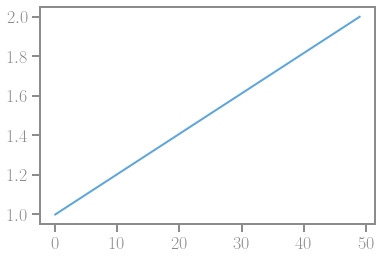

In [446]:
plt.plot(np.linspace(1., 2))

## Analyis helps

In [447]:
def _critical_load(matpar):
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]
    return np.sqrt(8*_w1 / (_mu*_k)/4)
    # independent of _N**2


def _homogeneous_state(t, matpar):
    """docstring for _homogeneous_state"""
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]


    # _tc = np.sqrt(matpar/k)
    # _a = (tau - 1) / (_k - 1)

    _tc = _critical_load(params["model"])
    _uh = [0 for i in range(0, _N+1)]
    
    if t <= _tc:
        # elastic
        _alphah = [0. for i in range(0, _N)]
        _uh = [i*t/_N for i in range(0, _N+1)]
    else:   
        # damaging
        _α = (t/_tc - 1) / (_k - 1)
        _alphah = [_α for i in range(0, _N)]

        # _S = reduce(lambda a, b: a+b, list(map(a_atk, _alphah)))
        
        _S = _N*a_atk(_α)

        _e = t / _N
        for i in range(0, _N+1):
            if i == 0:
                _uh[i] = 0
            else: 
                _uh[i] = _e * i
        # _uh = [a_atk(_α) / (_N*a_atk(_α)) * i/_N for i in range(0, _N+1)]
        # print(t, _e)
    return _alphah, _uh

In [448]:
class DefaultDamage:
    def __init__(self, state, matpar, name = "Default damage model: atk aka JJK aka LS", slug = "atk"):
        self.state = state
        self.matpar = matpar
        self.str = name
        self.slug = slug

    def _a(self, α):
        _α = self.state[α]
        # _α = α
        # _E0 = self.matpar[E0]
        _k = self.matpar[k]

        return (1 - α) / ((_k-1) * α + 1)

    def _w(self, _α):
        # _α = α
        # _w1 = self.matpar[w1]

        return _α

    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def _elastic(self, state):
        _E0 = self.matpar[E0]
        _u = state[u]
        _α = state[α]

        return 1./2. * _E0 * self._a(_α) * sp.diff(_u, x)**2 

    def _damage(self, state):
        _α = state[α]
        _w1 = matpar[w1]
        _𝓁 = matpar[𝓁]

        return _w1 * (self._w(_α) + matpar[𝓁]**2 * (sp.diff(_α, x))**2 )


    def __str__(self):
     return self.str


class DamageATSN(DefaultDamage):
    """docstring for Model"""
    def __init__(self, state, matpar, name = "ATk Damage Model, Seb Neukirch", slug = "atsn"):
        super(DefaultDamage, self).__init__(matpar, name = name)

    def _a(self, state):
        α = state[α]
        _E0 = self.matpar[E0]

        # return (1 - α)**2

    def _w(self, _α):
        _α = α
        _n = self.matpar[n]
        return 1-(1.-_α)**2


class DamageATn(DefaultDamage):
    """docstring for Model"""
    def __init__(self, state, matpar, slug, name = "ATn Damage Model"):
        super(DamageATn, self).__init__(state, matpar, name = name, slug = slug)

    def _a(self, α):
        return (1 - α)**2

    def _w(self, _α):
        _α = α
        _n = self.matpar[n]
        return _α**_n


class DamagePQ(DefaultDamage):
    """Particularly interesting model, as per marigo-2012"""
    def __init__(self, state, matpar = None, slug = "pq", name = "PQ Damage Model"):
        if matpar == {}:
            if matpar is None:
                p, q, E0, L, w1, 𝓁, σc = sp.symbols('p q E0 L w1 𝓁 σc')
                matpar = {p: p, q: q, E0: E0, w1: w1, 𝓁: 𝓁, L: L, σc: σc}

            self.matpar = matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, matpar, name = "PQ Damage Model", slug = slug)

    def _a(self, α):
        _q = self.matpar[q]
        _p = self.matpar[p]

        return (1 - α)**_q / (1 + α)**_p  

    def _w(self, _α):
        
        
        _α = α
        _q = self.matpar[q]
        _p = self.matpar[p]
        _σc = self.matpar[σc]
        _E0 = self.matpar[E0]

        return (_p+_q) * _α * _σc**2 / _E0


class DamagePQ2(DefaultDamage):
    """Particularly interesting other model, as per marigo-2012, 
        Requires: q > p > 0
    """
    def __init__(self, state, matpar = {}, slug = "pq2", name = "PQ Damage Model"):
        if matpar == {}:
            p, q, E0, L, w1, 𝓁, σc = sp.symbols('p q E0 L w1 𝓁 σc')
            _matpar = {p: p, q: q, E0: E0, w1: w1, 𝓁: 𝓁, L: L, σc: σc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model", slug = slug)

    def _a(self, α):
        _q = self._matpar[q]
        _p = self._matpar[p]

        return (1 - α)**_q 

    def _w(self, _α):
        
        _α = α
        _q = self._matpar[q]
        _p = self._matpar[p]
        _σc = self._matpar[σc]
        _E0 = self._matpar[E0]

        return _q * _σc**2 / (2.* _p * _E0)  * (1.-(1.-_α)**_p)


class PerfectBrittle(DefaultDamage):
    """Perfectly brittle model, as per marigo-2012, 
        w'/E' is constant
    """
    def __init__(self, state, matpar = {}, name = "PQ Damage Model", slug = "pq3"):
        if matpar == {}:
            p, q, E0, L, w1, 𝓁, σc = sp.symbols('p q E0 L w1 𝓁 σc')
            _matpar = {p: p, q: q, E0: E0, w1: w1, 𝓁: 𝓁, L: L, σc: σc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model", slug = "pq3")

    def _a(self, α):
        _q = self._matpar[q]
        _p = self._matpar[p]

        # return (1 - α)**_q 
        # return ?

    def _w(self, _α):
        
        _α = α
        _σc = self._matpar[σc]
        _E0 = self._matpar[E0]
        _ec = _σc / _E0

        return _E0 * (1 - self._a) * _ec**2 /2.


In [449]:
## Simple Analytic 
# import visuals
E0, L, w1, 𝓁, σc = sp.symbols('E0 L w1 𝓁 σc')
# k = sp.symbols('k', integer = True)
x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)


### Homogeneous sound solution
<!-- u = tx -->
<!-- alpha = 0 -->

In [450]:
class ModelAnalysis:
    """Helper class to analyse stability properties of a model"""

    def __init__(self, model):
        self.model = model
        self.state = model.state
        self.matpar = model.matpar

        self._s = 1/self.model._a(state[α])
        self._sp = sp.diff(self._s, state[α], 1)
        self._spp = sp.diff(self._s, state[α], 2)

        self._a = self.model._a(state[α])
        self._ap = sp.diff(self._a, state[α], 1)
        self._app = sp.diff(self._a, state[α], 2)

        self._w = self.model._w(state[α])
        self._wp = sp.diff(self._w, state[α])
        self._wpp = sp.diff(self._w, state[α], 2)

    def _print_model_functions(self, matpar = {}):
        if matpar == {}:
            _fname = f"model-{self.model.slug}.txt"
        else: 
            _fname = f"model-{self.model.slug}-matpar.txt"
        print(f"Output in {_fname}")

        sp.latex(self._a)
        sp.latex(self._ap)
        sp.latex(self._app)
        sp.latex(self._s)
        sp.latex(self._sp)
        sp.latex(self._spp)
        
        _fcs = [self._a.subs(matpar), 
            self._ap.subs(matpar), 
            self._app.subs(matpar), 
            self._s.subs(matpar), 
            self._sp.subs(matpar), 
            self._spp.subs(matpar)]
        _lab = ["a", "aprime", "apprime", "s", "sprime", "spprime"]
        _known = ["a(\\alpha)=", "a'(\\alpha)=", "a''(\\alpha)=", 
                "s(\\alpha)=", "s'(\\alpha)=", "s''(\\alpha)="]

        out_file = open(_fname,"w")
        
        for y in zip(_fcs, _lab, _known):
            _tex = y[2] + str(sp.latex(y[0])).replace("α", "\\alpha")
            out_file.write("\\begin{equation}")
            out_file.write(f"\\label{{ eqn:{self.model.slug}-{y[1]} }}")
            out_file.write(_tex)
            out_file.write("\\end{equation}")
            out_file.write("\n")

        out_file.close()

        _σ = sp.symbols('σ')
        _β = sp.symbols('β')
        _α0 = sp.symbols('α0')
        _γ = sp.symbols('γ')
        _E0 = self.model.matpar[E0]

        _fch = self._H_damage_profile()

        fc0 = self.criterion()
        fc1 = self.critical_load()
        fc3 = _fch.subs(matpar).subs({_β: -_γ/_α0+1})
        fc4 = (1/sp.sqrt(
                _fch.subs(matpar))
                ).simplify()
        fc5 = ((self._s - 1/E0).subs(α, _β)/sp.sqrt(_fch))    \
            .subs(matpar)                                              \
            .simplify()

        fc6 = (((self._s - 1/E0).subs(α, _β)/sp.sqrt(_fch)))    \
            .subs(matpar).subs({_β: -_γ/_α0+1})                \
            # .simplify()
        
        fc7 = _fch.subs(matpar).subs({_β: -_γ/_α0+1})
        fc7_γ = sp.diff(fc7, _γ).subs({_γ: 1}).simplify()
        # Hσγ_γ.simplify()
        fc6_γ = sp.diff(fc6, _γ).subs({_γ: 1}).subs(matpar).simplify()

        _fcs = [fc0, fc1, _fch, 
                # fc2, 
                fc3, fc4, fc5, fc6, fc7, fc7_γ, fc6_γ]
        _lab = ["crit", "crit_load", "Hsigmabeta", 
                # "Hsigmagamma", 
                "Hsigmabeta_mat", "one_over_H",
                "eps_integrand", 
                "eps_integrand_gamma", 
                "deriv_integrand_gamma", 
                "deriv_integrand_gamma_one", 
                "deriv_integrand_gamma_one", 
                ]
        _known = ["0=", "t_c=", 
                "H(\\sigma, \\beta)=", 
                # "H(\\sigma, \\beta)=",
                "H(\\sigma, \\gamma)=",
                "1/\\sqrt{H(\\sigma, \\beta)}=",
                "(S(\\beta)-S_0)/\\sqrt{H(\\sigma, \\beta)}=",
                "(S(\\gamma)-S_0)/\\sqrt{H(\\sigma, \\gamma)}=",
                "\\frac{\\partial H}{\\partial \\gamma}=",
                "\\frac{\\partial H}{\\partial \\gamma}|_{\\gamma=1}=",
                "\\frac{\\partial 1/\\sqrt{H}}{\\partial \\gamma}|_{\\gamma=1}="
                ]

        out_file = open(_fname,"a")
        out_file.write("\n")
        
        for y in zip(_fcs, _lab, _known):
            print(y[2])
            _tex = y[2] + str(sp.latex(y[0])).replace("α", "\\alpha") \
                                    .replace("σ", "\\sigma")    \
                                    .replace("β", "\\beta")    \
                                    .replace("γ", "\\gamma")    
            out_file.write("\\begin{equation}")
            out_file.write(f"\\label{{ eqn:{self.model.slug}-{y[1]} }}")
            out_file.write(_tex)
            out_file.write("\\end{equation}")
            out_file.write("\n")

        out_file.close()

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state

        _u0 = t*x/L
        _alpha0 = 0

        _crit = sp.diff(model.energy(state), α) \
            .subs({u: _u0, α: _alpha0})         \
            .simplify()
        # .subs(matpar).simplify()
        # _ts = np.array(sp.solve(_crit, t))
        # return np.where(_ts > 0)
        self.crit = _crit

        return _crit

    def _homogeneous_energy(self, _matpar):
        state, (_uf, _af) = self._homogeneous_state(_matpar)

        _u = state[0]
        _alpha = state[1]

        return

    def critical_load(self):
        ans = sp.solve(self.crit, t)
        _ = [t.subs(_matpar) for t in ans]
        positive = np.where(np.array(_) > 0)[0][0]
        # pdx
        self._critical_load = ans[positive]
        return ans[positive]

    def critical_load_N(self, _matpar={}):
        return np.float64(self._critical_load.subs(_matpar))

    def set_critical_load(self, _critical_load):
        self._critical_load = _critical_load

    def _check_constitutive(self):
        _a = 1
        # a -> E(a) decreasing
        # a -> w(a) increasing
        # a -> -w'/E' increasing
        # a -> -w'/s' decreasing
        return

    def _homogeneous_alpha(self, matpar = None):
        _u0 = t*x/L

        if matpar is not None:
            _matpar = matpar
        else:
            _matpar = self.matpar

        try:
            _eq = sp.diff(self.model.energy(state), α) \
                .subs({u: _u0, α: α})         \
                .simplify()

            _ah = sp.solve(_eq, α)

        # except NotImplementedError as e:
        except:
            _eq = sp.diff(ana.model.energy(state), α)   \
                .subs({u: _u0, α: α})                   \
                .subs(_matpar)                   \
                .simplify()

            _ah = sp.solve(_eq, α)

        return _ah

    def plot_homogeneous_alpha(self, _matpar={}):
        ah = self._homogeneous_alpha()
        _tc = self.critical_load_N(_matpar)

        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        subcritical_times = np.linspace(0., _tc)
        axis.plot(subcritical_times, [0 for t in subcritical_times], c="C0")

        supercritical_times = np.linspace(_tc, 3)

        for _a in ah:
            _af = sp.lambdify(t, _a.subs(_matpar), "numpy")

            axis.plot(supercritical_times, [_af(t)
                      for t in supercritical_times], c="C0")
            # plt.plot()

        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        return fig, axis

    def plot_homogeneous_stress(self, _matpar={}, ah=None):
        ah = self._homogeneous_alpha()
        # _tc = self.critical_load_N(_matpar)
        try:
            _tc = self.critical_load_N(_matpar)
        except:
            _tc = self._critical_load
        print(f"_tc {_tc}")
        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        times = np.linspace(0, 3, 30)

        _sf = sp.lambdify(t, self._stress(ah=ah).subs(_matpar), "numpy")

        # axis.plot(np.linspace(0, 3), [_sf(t) for t in times], c="C0")
        axis.plot(_times, [_sf(t) for t in _times], c="C0")

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        return fig, axis

    def _homogeneous_state(self, _matpar={}, ah=None):
        if ah is None:
            # Good luck with the first solution
            _ah = self._homogeneous_alpha()[0]
        else:
            _ah = ah
        try:
            _tc = self.critical_load_N(_matpar)
        except:
            _tc = self._critical_load

        x, t = sp.symbols('x t')
        print(_tc)
        _homogeneous_alpha = sp.Piecewise((_ah, t >= _tc), (0, t < _tc))
        _homogeneous_u = t * x / L

        _uf = sp.lambdify((t, x), _homogeneous_u.subs(_matpar), "numpy")
        _af = sp.lambdify(t, _homogeneous_alpha.subs(_matpar), "numpy")

        state = {u: _homogeneous_u, α: _homogeneous_alpha}

        return state, (_uf, _af)

    def _set_homogeneous_alpha(self, ah):
        self._alpha_h = ah

        return

    def plot_homogeneous_energies(self, _matpar):

        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar)

        _en_h = sp.lambdify(t, at1.energy(_homog_state).subs(
            {α: _homog_state[1]}).subs(_matpar), "numpy")
        _en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs(
            {α: _homog_state[1]}).subs(_matpar), "numpy")
        _en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs(
            {α: _homog_state[1]}).subs(_matpar), "numpy")
        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        plt.plot(np.linspace(0., 3.), [_en_h(t)
                 for t in np.linspace(0., 3.)], c="C0")
        plt.plot(np.linspace(0., 3.), [_en_dam_h(t)
                 for t in np.linspace(0., 3.)], c="C1")
        plt.plot(np.linspace(0., 3.), [_en_ela_h(t)
                 for t in np.linspace(0., 3.)], c="C2")

        return fig, axis

    def plot_material(self, _matpar):
        _damage = np.linspace(0., 1.)

        _af = sp.lambdify(α, self._a.simplify().subs(_matpar), "numpy")
        _apf = sp.lambdify(α, self._ap.simplify().subs(_matpar), "numpy")
        _appf = sp.lambdify(α, self._app.simplify().subs(_matpar), "numpy")

        # _apf = sp.lambdify(t, ana.)ap.subs(_matpar), "numpy")
        # _apf

        figure, axis = plt.subplots(1, 2, figsize=(8, 6))
        _ax = axis[0]
        _ax.axhline(0, c='k')
        _ax.plot(_damage, [_af(α) for α in _damage], label="a")
        _ax.legend(loc=2)
        # _ax.twiny()
        _ax.plot(_damage, [_apf(α) for α in _damage], label="a'", c='r')
        _ax.plot(_damage, [_appf(α) for α in _damage], label="a''")
        _ax.set_xlim(0, 1)
        _ax.legend()

        _sf = sp.lambdify(α, self._s.simplify().subs(_matpar), "numpy")
        _spf = sp.lambdify(α, self._sp.simplify().subs(_matpar), "numpy")
        _sppf = sp.lambdify(α, self._spp.simplify().subs(_matpar), "numpy")

        _ax = axis[1]

        _ax.plot(_damage, [_sf(α) for α in _damage], label="s")
        _ax.legend(loc=2)
        _ax.axhline(0, c='k')
        _ax.twinx()
        _ax.plot(_damage, [_spf(α) for α in _damage], label="s'")
        _ax.plot(_damage, [_sppf(α) for α in _damage], label="s''")
        _ax.set_xlim(0, 1)
        _ax.set_ylim(0, 10)
        _ax.legend(loc=1)
        figure.suptitle(f"Behaviour of {self.model.__str__()} is Material")

        return figure, axis

    def _hypotheses1(self):
        """As per marigo-2012, HP1: w'/S' decreasing wrt alpha"""

        _hp1 = self._sp / self._wp
        return _hp1

    def _H_damage_profile(self):
        """A function of sigma and beta constructs localisation profiles"""
        _σ = sp.symbols('σ')
        _β = sp.symbols('β')

        _Hf = 1/E0*(2*self._w - _σ**2 * (self._s - 1/E0)).subs({α: _β})

        return _Hf

    def max_α(self, matpar = {}):
        """Maximum value of alpha as a function of sigma"""
        _β = sp.symbols('β')
        _σ = sp.symbols('σ')
            
        sol = sp.solve(self._H_damage_profile().subs(matpar), _β)

        # simple tet
        arr = np.array([a.subs({_σ: .9}) for a in sol])
        idx = np.argwhere((arr > 0) & (arr < 1)).flatten()[0]

        return sol, idx

    def _α_max(self, σ, matpar = None):
        _β = sp.symbols('β')
        _σ = sp.symbols('σ')
        # _matpar = self.matpar
        _Hσβ = self._H_damage_profile().subs(matpar)

        _Hβ = _Hσβ.subs({_σ: σ})
        _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect')
        # print(_sol)
        αmax = np.float64(_sol[1][0])

        return αmax

    def _stress(self, ah=None):
        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar, ah=ah)

        _ah = _homog_state[α]

        _tc = self.critical_load_N(_matpar)

        stress_alpha = sp.Piecewise(
            (sp.sqrt(2 * self._wp / self._sp).subs({α: _ah}), t >= _tc),
            # sigma = E(alpha=0) u'
            (sp.diff(_homog_state[u], x).subs(_matpar), t < _tc))

        # return sp.sqrt( 2* self._wp / self._sp).subs({α: _ah})
        return stress_alpha

    def _Dσ(self, σ):
        """Half length of the localisation as a function of σ"""
        _αh = self._homogeneous_alpha()
        _β = sp.symbols('β')
        _αmax = self._α_max(σ)

        _E0 = self.model._matpar[E0]
        _𝓁 = self.model._matpar[𝓁]

        _f = 1/self._H_damage_profile()

        _Dσ = _𝓁 * sp.integrate(_f, (_β, 0, _αmax))

    def _Dc(self):
        """Half length of the localisation at the onset"""
        _αh = self._homogeneous_alpha()
        _E0 = self.model._matpar[E0]
        _D = np.pi * 𝓁 * \
            sp.sqrt(2 * _E0 / (σ * self._spp - 2.*self._wpp)).subs({α: 0})

    def snap_back(self, matpar):
        _α = self.model.state[α]
        _E0 = self.model.matpar[E0]
        _w1 = self.model.matpar[w1]
        S0 =  1 / _E0
        _σc = sp.sqrt( 2* self.model.matpar[w1]*self._wp / (S0*self._sp) ).subs({α: 0})
        _sp = self._sp
        _w = self._w

    def _eps_1_d(self, σv, matpar, tol = 1e-3):
        # _β = sp.symbols('β')
        # _α_max = self._α_max(σv, matpar)
        # _f = (self._s - 1/E0).subs(α, _β)/sp.sqrt(self._H_damage_profile())    \
        #     .subs(matpar)                                                   \
        #     .subs({_σ: σv})                                                   \
        #     .simplify()

        # __fv = sp.lambdify(_β, f.subs(matpar), "numpy")
        # _tol = 0.001
        _betas = np.linspace(_tol, _α_max - tol, 30)
        _f, _α_max, __fv = self._eps_1_d_integrand(σv, matpar)
        eps = np.trapz([__fv(b) for b in _betas], _betas)

        return eps, (_f, _α_max)

    def _eps_1_d_integrand(self, σv, matpar):
        _β = sp.symbols('β')
        _α_max = self._α_max(σv, matpar)

        _f = ((self._s - 1/E0).subs(α, _β)/sp.sqrt(self._H_damage_profile()))    \
            .subs(matpar)                                                       \
            .subs({_σ: σv})                                                   \
            .simplify()

        __fv = sp.lambdify(_β, _f.subs(matpar), "numpy")

        return _f, _α_max, __fv




        return - ((np.pi * 2**(5/2) * (S0 * _sp)**2 * _σc**2 * _E0**1/2) /
                  (S0*self._spp * _σc**2 - 2. * _w1 * self._wpp) ** (3/2))       \
                    .subs({α: 0}).subs(matpar)

    # check: dependence of localisation zone wrt stress
    # check: global maccro response


In [451]:
E0, L, w1, 𝓁, σc = sp.symbols('E0 L w1 𝓁 σc')
k = sp.symbols('k', integer = True)

x, t = sp.symbols('x t')

_α0 = sp.symbols('α0')
_γ = sp.symbols('γ')


α = sp.Function('α')(x)
u = sp.Function('u')(x)

state = {u: u, α: α}

# sp.diff(atk.elastic(state), α).subs({u: _u0}).simplify()



In [452]:
# _times = np.linspace(0., atk.matpar)
_times = np.linspace(0., 3.)
_damage = np.linspace(0., 1.)


## ATk

In [453]:
state = {u: u, α: α}
_matpar = {k: 2, E0: 1, w1: 1, 𝓁:𝓁, L: 1}
matpar = {k: k, E0: E0, w1: w1, 𝓁:𝓁, L: L}

_u0 = t*x/L
_alpha0 = 0 

atk = DefaultDamage(state, matpar)
ana = ModelAnalysis(atk)
_crit = sp.diff(atk.energy(state), α).subs({u: _u0, α: _alpha0}).simplify()
_crit




-0.5*E0*k*t**2/L**2 + 1.0*w1

### First order

In [31]:
sp.diff(ana.model.energy(state), α).subs({u: _u0, α: α}).simplify()

-0.5*E0*k*t**2/(L**2*(k*α(x) - α(x) + 1)**2) + w1

In [32]:
ana.criterion()

-0.5*E0*k*t**2/L**2 + 1.0*w1

In [34]:
ana._print_model_functions(_matpar)
ana._print_model_functions()

Output in model-atk-matpar.txt
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=
\frac{\partial H}{\partial \gamma}=
\frac{\partial H}{\partial \gamma}|_{\gamma=1}=
\frac{\partial 1/\sqrt{H}}{\partial \gamma}|_{\gamma=1}=
Output in model-atk.txt
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=
\frac{\partial H}{\partial \gamma}=
\frac{\partial H}{\partial \gamma}|_{\gamma=1}=
\frac{\partial 1/\sqrt{H}}{\partial \gamma}|_{\gamma=1}=


In [36]:
ana.critical_load_N(_matpar)

1.0

In [37]:
ana.set_critical_load(ana.critical_load())
# ana.set_critical_load(ana.critical_load_N(_matpar))
ana._critical_load

1.4142135623731*L*sqrt(w1/(E0*k))

In [38]:
_ = sp.diff(atk.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

In [39]:
_
sp.latex(_)

'- \\frac{0.5 E_{0} k t^{2}}{L^{2} \\left(k α{\\left(x \\right)} - α{\\left(x \\right)} + 1\\right)^{2}} + w_{1}'

In [40]:
ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])

1.4142135623731*L*sqrt(w1/(E0*k))


({u(x): t*x/L,
  α(x): Piecewise(((-L*w1 + 0.707106781186548*t*sqrt(E0*k*w1))/(L*w1*(k - 1.0)), t >= 1.4142135623731*L*sqrt(w1/(E0*k))), (0, True))},
 (<function _lambdifygenerated(t, x)>, <function _lambdifygenerated(t)>))

In [41]:
_eq = sp.diff(atk.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

_eq

_ah = sp.solve(_eq, α)

[a.subs(_matpar) for a in _ah]


[-0.707106781186548*sqrt(2)*t - 1.0, 0.707106781186548*sqrt(2)*t - 1.0]

(0.0, 2.0)

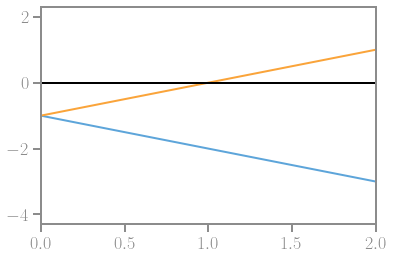

In [42]:
_eq = sp.diff(atk.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

_ah = sp.solve(_eq, α)


_ah_f = [sp.lambdify(t, a.subs(_matpar), "numpy") for a in _ah]

# _ahp = sp.lambdify(t, _ah_sub[0].subs(_matpar), "numpy")

_times = np.linspace(0., 3)

for _a in _ah_f:
    plt.plot(_times, [_a(t) for t in _times])

plt.axhline(0, c='k')
plt.xlim(0, _matpar[k])
# plt.plot()

### Check if multiple solutions

In [43]:
_state, (_uf, _af) = ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])

1.4142135623731*L*sqrt(w1/(E0*k))


In [44]:
_state

{u(x): t*x/L,
 α(x): Piecewise(((-L*w1 + 0.707106781186548*t*sqrt(E0*k*w1))/(L*w1*(k - 1.0)), t >= 1.4142135623731*L*sqrt(w1/(E0*k))), (0, True))}

In [45]:
_ = _state[α]

In [46]:
sp.latex(_)

'\\begin{cases} \\frac{- L w_{1} + 0.707106781186548 t \\sqrt{E_{0} k w_{1}}}{L w_{1} \\left(k - 1.0\\right)} & \\text{for}\\: t \\geq 1.4142135623731 L \\sqrt{\\frac{w_{1}}{E_{0} k}} \\\\0 & \\text{otherwise} \\end{cases}'

In [47]:
# _a = _state[α]
# _a.subs(_matpar)

In [48]:
_a

<function _lambdifygenerated(t)>

In [49]:
_a = _state[α]

_ah_f = sp.lambdify(t, _a.subs(_matpar), "numpy")
_ah_f(0)

array(0.)

In [50]:
ana.critical_load_N(_matpar)

1.0

Text(0.5, 1.0, 'Default damage model: atk aka JJK aka LS')

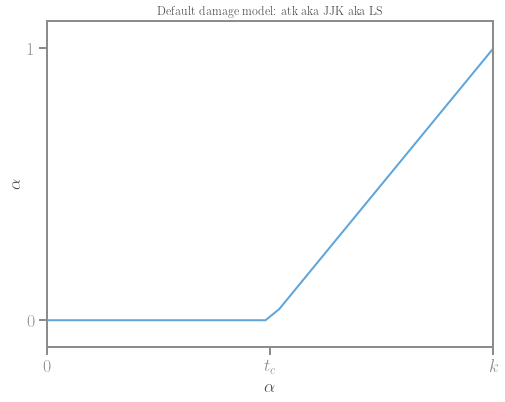

In [52]:
fig, axis = plt.subplots(1, 1, figsize=(8, 6))

axis.plot(_times, [_ah_f(t) for t in _times])
tc = ana.critical_load_N(_matpar)

# axis.axhline(0, c='k')
axis.set_xlim(0, _matpar[k])
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, _matpar[k]], ["0", "$t_c$", "$k$"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$\\alpha$")
axis.set_ylabel("$\\alpha$")
axis.set_title(f"{ana.model}")


In [ ]:
fig.tight_layout()
fig.savefig("../../notes/figures/atk-alpha-homog.pdf")

In [56]:
state

{u(x): u(x), α(x): α(x)}

In [58]:
atk.energy(_homog_state)

NameError: name '_homog_state' is not defined

### Material

<lambdifygenerated-17>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (-_Dummy_353 - 1)/(_Dummy_353 - 1)
<lambdifygenerated-18>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2/(_Dummy_354**2 - 2*_Dummy_354 + 1)
<lambdifygenerated-19>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return -4/(_Dummy_355**3 - 3*_Dummy_355**2 + 3*_Dummy_355 - 1)


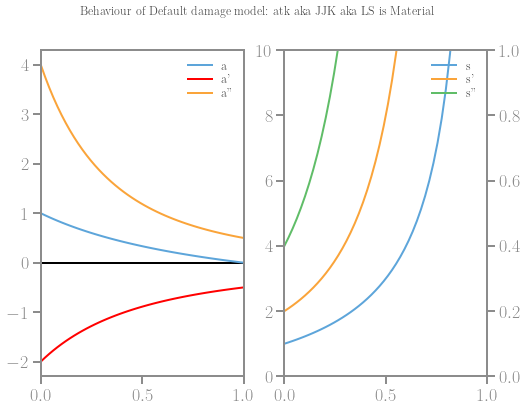

In [59]:
figure, axis = ana.plot_material(_matpar)
# axis[0].set_ylim(-1, 2)
# axis[1].set_ylim(-1, 2)


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/atk-model.pdf")

In [60]:
# Localised branches
ana._s, ana._sp.simplify(), ana._spp.simplify()

(((k - 1)*α(x) + 1)/(1 - α(x)),
 k/(α(x)**2 - 2*α(x) + 1),
 -2*k/(α(x)**3 - 3*α(x)**2 + 3*α(x) - 1))

1.0


(0.0, 100.0)

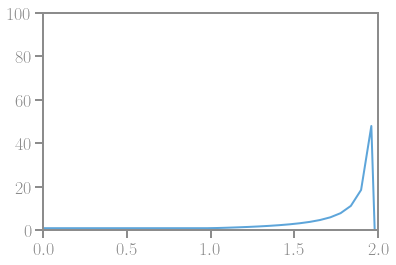

In [61]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar, ah = ana._homogeneous_alpha()[1])


_s = ana._s.subs({α: _homog_state[α]}).subs(_matpar)
_sf = sp.lambdify(t, _s, "numpy")

plt.plot(_times, [_sf(t) for t in _times], c="C0")
plt.xlim(0, _matpar[k])
plt.ylim(0, 100)


In [62]:
_en_h = sp.lambdify(t, atk.energy(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, atk._damage(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, atk._elastic(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")

plt.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0")
plt.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1")
plt.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2")


KeyError: Piecewise(((-L*w1 + 0.707106781186548*t*sqrt(E0*k*w1))/(L*w1*(k - 1.0)), t >= 1.0), (0, True))

1.0


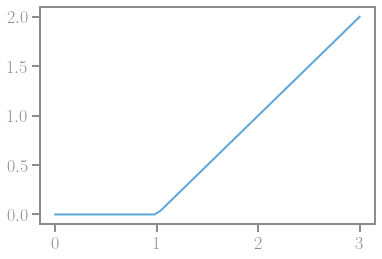

In [63]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar, ah = ana._homogeneous_alpha()[1])


_w = ana._w.subs({α: _homog_state[α]}).subs(_matpar)
_wf = sp.lambdify(t, _w, "numpy")

plt.plot(_times, [_wf(t) for t in _times], c="C0")


### Localised branches and H-

<lambdifygenerated-216>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.9801 - 0.9801*(β + 1)/(1 - β)
<lambdifygenerated-217>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.834177777777778 - 0.834177777777778*(β + 1)/(1 - β)
<lambdifygenerated-218>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.700011111111111 - 0.700011111111111*(β + 1)/(1 - β)
<lambdifygenerated-219>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.5776 - 0.5776*(β + 1)/(1 - β)
<lambdifygenerated-220>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.466944444444444 - 0.466944444444444*(β + 1)/(1 - β)
<lambdifygenerated-221>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.368044444444444 - 0.368044444444444*(β + 1)/(1 - β)
<lambdifygenerated-222>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β +

(-1.0, 2.0)

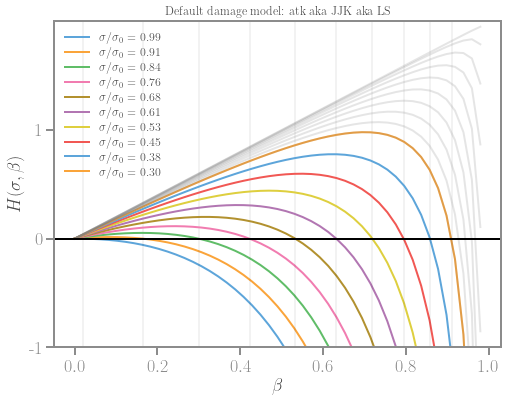

In [231]:
_Hσβ = ana._H_damage_profile().subs(_matpar)

_σ = sp.symbols('σ')
_β = sp.symbols('β')

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for sigmav in np.linspace(.99, .3, 10):
# for sigmav in np.arange(2, 5):
    _Hβ = _Hσβ.subs({_σ: sigmav})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    αmax = _sol[1][0]
    axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = {sigmav:.2f}")
    # axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    axis.axvline(αmax, c='k', lw=.1)

for sigmav in np.linspace(.3, .01, 10):
# for sigmav in np.arange(2, 5):
    _Hβ = _Hσβ.subs({_σ: sigmav})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    αmax = _sol[1][0]
    axis.plot(_damage, [_Hβf(β) for β in _damage], 
        # label = f"$\sigma/\sigma_0$  = {sigmav:.2f}", 
        c='gray',
        alpha = .2
        )
    # axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    # axis.axvline(αmax, c='k', lw=.1)



axis.set_ylabel("$H(\\sigma, \\beta)$")
axis.set_xlabel("$\\beta$")
axis.set_title(f"{ana.model}")
axis.legend()
axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis.set_ylim(-1, 2)


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/atk-Hbeta.pdf")

In [76]:
ana._s

((k - 1)*α(x) + 1)/(1 - α(x))

In [65]:
ana._a

(1 - α(x))/((k - 1)*α(x) + 1)

In [85]:
_α0

α0

In [232]:
_subs_sing = {α: _γ*_α0}
_h = (2*ana._w - _σ**2 * (ana._s - 1/E0)).subs(_matpar).subs(_subs_sing)

_h

2*α0*γ - σ**2*(-1 + (α0*γ + 1)/(-α0*γ + 1))

In [233]:
_hprime = sp.diff(_h, _γ)
_hprime

2*α0 - σ**2*(α0/(-α0*γ + 1) + α0*(α0*γ + 1)/(-α0*γ + 1)**2)

(-1.0, 2.0)

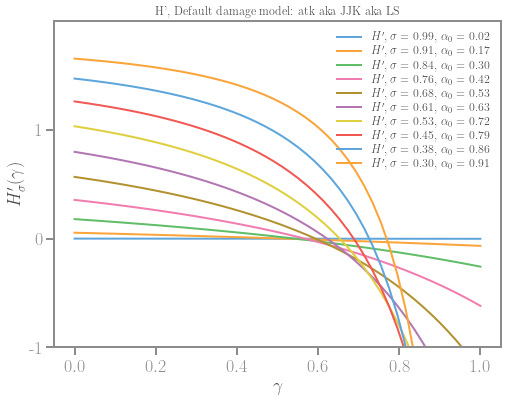

In [234]:
_σ = sp.symbols('σ')
_β = sp.symbols('β')
_Hσβ = ana._H_damage_profile().subs(_matpar)

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for sigmav in np.linspace(.99, .3, 10):
    _Hβ = _Hσβ.subs({_σ: sigmav})

    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 

    αmax = _sol[1][0]
    # print(amax)
    _hprimeS = _hprime.subs({_σ: sigmav, _α0: αmax})
    _hprimeSf = sp.lambdify(_γ, _hprimeS, "numpy")

    # _hprimeSf
    axis.plot(_damage, [_hprimeSf(β) for β in _damage], label = f"$H', \\sigma =$ {sigmav:.2f}, $\\alpha_0 = $ {_sol[1][0]:.2f}")
    # axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    # axis.axvline(αmax, c='k', lw=.1)


axis.set_ylabel("$H'_\\sigma(\\gamma)$")
axis.set_xlabel("$\\gamma$")
axis.set_title(f"H', {ana.model}")
axis.legend()
# axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis.set_ylim(-1, 2)


In [235]:
_h

2*α0*γ - σ**2*(-1 + (α0*γ + 1)/(-α0*γ + 1))

In [236]:
_h**(-1/2)

(2*α0*γ - σ**2*(-1 + (α0*γ + 1)/(-α0*γ + 1)))**(-0.5)

In [237]:
(sp.solve((2*ana._w - _σ**2 * (ana._s - 1/E0)), α)[0]).subs(_matpar).simplify()

-σ**2/2 - sqrt(σ**4 - 2*σ**2 + 1)/2 + 1/2

In [239]:
sp.diff(_h, _γ).subs({_γ: 0})

-2*α0*σ**2 + 2*α0

In [240]:
sp.diff(_h, _γ).subs({_γ: 1})

2*α0 - σ**2*(α0/(1 - α0) + α0*(α0 + 1)/(1 - α0)**2)

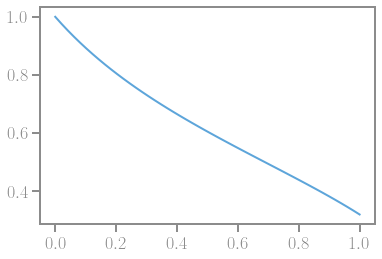

In [241]:
_C = sp.symbols('C', real = True)
_f = _C*x+(_C*x+1)/(1-_C*x)

# sp.integrate(_f**(-1/2), x)
sp.integrate(_f**(-1/2), (x, 0, 1))

_ff = sp.lambdify(x, (_f**(-1/2)).subs({_C: .8}), "numpy")

plt.plot(_damage, [_ff(t) for t in _damage], c="C0")


In [123]:
np.trapz([_ff(b) for b in _damage], _damage)

0.6591210806835514

In [139]:
_h = (2*ana._w - _σ**2 * (ana._s - 1/E0)).subs(_matpar).subs(_subs_sing)

(1/_h**(1/2))
# .simplify()

(2*α0*γ - σ**2*(-1 + (α0*γ + 1)/(-α0*γ + 1)))**(-0.5)

<lambdifygenerated-212>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*(-1 + (0.8*γ + 1)/(1 - 0.8*γ))**(-0.5)
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_80390/530160613.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  plt.plot(_damage, [1/(t)**(1/2) for t in _damage], c="C1")
/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_80390/530160613.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  plt.plot(_damage, [1/(t)**(1/3) for t in _damage], c="C2")


[]

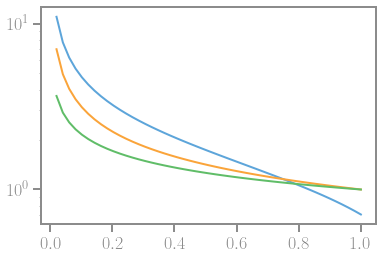

In [224]:
_subs_sing = {α: _γ*_α0}
# _h = (2*ana._w - _σ**2 * (ana._s - 1/E0)).subs(_matpar).subs(_subs_sing)
_h = (_σ**2 *(ana._s - 1/E0)).subs(_matpar).subs(_subs_sing)

# _h
_sqrt_h = (_h**(-1/2)).subs({_α0: .8, _σ: .5})
# _sqrt_h
_ff = sp.lambdify(_γ, _sqrt_h, "numpy")
plt.plot(_damage, [_ff(t) for t in _damage], c="C0")
plt.plot(_damage, [1/(t)**(1/2) for t in _damage], c="C1")
plt.plot(_damage, [1/(t)**(1/3) for t in _damage], c="C2")
plt.semilogy()



In [144]:
_h = (2*ana._w -_σ**2 *(ana._s - 1/E0)).subs(_matpar).subs(_subs_sing)
_h.simplify()

_G = _h.simplify()

In [146]:
_G.subs({_γ: 0}), _G.subs({_γ: 1})

(0, 2*α0*(α0 + σ**2 - 1)/(α0 - 1))

In [150]:
sp.integrate((_h**(-1/2)).subs({_α0: .8, _σ: .5}), (_γ, 0, 1))

0.883883476483184*Integral(1/(γ**0.5*(-1.0*γ/(1 - 0.8*γ) + 0.9375/(1 - 0.8*γ))**0.5), (γ, 0, 1))

In [66]:
_Hσβ = ana._H_damage_profile()
_Hσβ
# Linéaire - linéaire (JJK)

(2*β - σ**2*((β*(k - 1) + 1)/(1 - β) - 1/E0))/E0

In [155]:
((_h)**(-1/2)).subs({_α0: .8, _σ: .5})

0.790569415042095/(γ + 0.15625 - 0.15625*(0.8*γ + 1)/(1 - 0.8*γ))**0.5

<lambdifygenerated-215>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.790569415042095*(γ + 0.15625 - 0.15625*(0.8*γ + 1)/(1 - 0.8*γ))**(-0.5)
<lambdifygenerated-215>:2: RuntimeWarning: invalid value encountered in double_scalars
  return 0.790569415042095*(γ + 0.15625 - 0.15625*(0.8*γ + 1)/(1 - 0.8*γ))**(-0.5)


[]

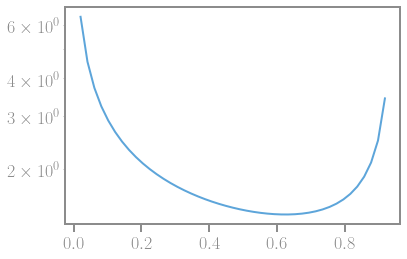

In [230]:
from scipy.integrate import quad
_h = (2*ana._w -_σ**2 *(ana._s - 1/E0)).subs(_matpar).subs(_subs_sing)
_fv = sp.lambdify(_γ, ((_h)**(-1/2)).subs({_α0: .8, _σ: .5}), "numpy")
# _fv(.9)
# quad(_fv, 0, 1)
plt.plot(_damage, [_fv(b) for b in _damage])
plt.semilogy()


In [229]:
_Hσβ = ana._H_damage_profile().subs(_matpar)
_Hσβ

2*β - σ**2*(-1 + (β + 1)/(1 - β))

In [227]:
_Hσβ = ana._H_damage_profile().subs(_matpar)
Hσβ_β = sp.diff(_Hσβ, _β)
Hσβ_β

-σ**2*(1/(1 - β) + (β + 1)/(1 - β)**2) + 2

In [68]:
Hσβ_β.subs({_β: 0})


2 - 2*σ**2

In [ ]:
_Hσβ_α0 = ana._H_damage_profile().subs(_matpar).subs({_β: 1-_γ*_α0})
_Hσβ_α0


In [ ]:
sp.diff(_Hσβ_α0, _γ)


In [69]:
amax = []
for i in np.linspace(.99, .3, 10):
    amax.append(ana._α_max(i, _matpar))


amax

[0.0199,
 0.16582222222222223,
 0.2999888888888889,
 0.4224,
 0.5330555555555555,
 0.6319555555555556,
 0.7191,
 0.7944888888888889,
 0.8581222222222222,
 0.91]

In [70]:
for a in amax:
    _Hσβ_α0.subs({_α0: a})
    # print(a, _Hσβ_α0)

NameError: name '_Hσβ_α0' is not defined

Text(0.5, 1.0, 'Default damage model: atk aka JJK aka LS')

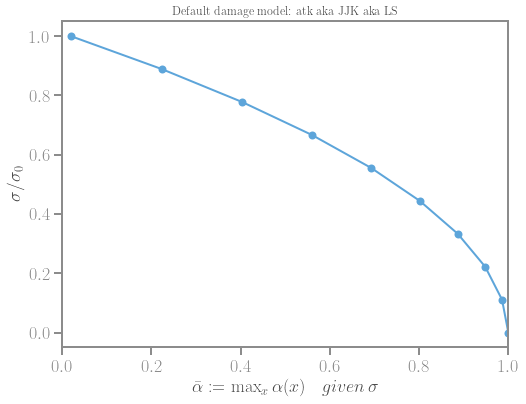

In [71]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))

amax = []
for i in np.linspace(.99, .01, 10):
    amax.append(ana._α_max(i, _matpar))


axis.plot(amax, np.linspace(1, .0, 10), marker='o')
axis.set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
axis.set_ylabel('$\\sigma/\\sigma_0$')
axis.set_xlim(0., 1.)
axis.set_title(f"{ana.model}")

# plt.plot(np.linspace(-.99, -.2, 10), amax)

In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/atk-maxalpha.pdf")

In [ ]:
matpar

In [75]:
ana.snap_back(_matpar) 
# < 0

In [73]:
print(ana.model)

Default damage model: atk aka JJK aka LS


In [ ]:
_Hσγ = ana._H_damage_profile().subs(_matpar).subs({_β: _α0*_γ})
Hσγ_γ = sp.diff(_Hσγ, _γ)
# Hσγ_γ.simplify().subs({_γ: 1})
Hσγ_γ




In [ ]:
_matpar

In [ ]:
_h = ana._H_damage_profile().subs(_matpar).subs({_β: -_γ/_α0+1})
_g = (ana._s - 1/E0).subs(α, _β).subs({_β: -_γ/_α0+1})/sp.sqrt(_h)
_g.subs(_matpar)
# .simplify()

# ((ana._s - 1/E0).subs(α, _β)

In [ ]:
_g.subs(_matpar).subs({_α0:1}).subs({_γ:.999})

In [ ]:
_g_γ = sp.diff(_g.subs(_matpar).subs({_α0: 1}), _γ).simplify()
_g_γ

In [ ]:
# _g_γ.subs({})
_g_γ.subs({_γ:0})

## ATn

In [454]:
## Simple Analytic 
# import visuals

E0, L, w1, 𝓁, σc = sp.symbols('E0 L w1 𝓁 σc')
x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)

n = sp.symbols('n')


#### ATn, n=1 => AT1

In [456]:
state = {u: u, α: α}
matpar = {n: 1, E0: 1, w1: 1, 𝓁:𝓁}
_matpar = {n: 1, L: 1, E0: 1, w1: 1, 𝓁:𝓁}

at1 = DamageATn(state, matpar={n: 1, E0: E0, w1: w1, 𝓁:𝓁, L: L}, name="At1 Damage Model", slug=f"at1")
ana = ModelAnalysis(model = at1)

_ = ana.criterion()
_
# ana.critical_load()
# ana._homogeneous_alpha()
print(ana.model)


At1 Damage Model


#### First order

In [457]:
ana.model.slug

'at1'

In [245]:
ana._print_model_functions()
ana._print_model_functions(_matpar)

Output in model-at1.txt
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=
\frac{\partial H}{\partial \gamma}=
\frac{\partial H}{\partial \gamma}|_{\gamma=1}=
\frac{\partial 1/\sqrt{H}}{\partial \gamma}|_{\gamma=1}=
Output in model-at1-matpar.txt
0=
t_c=
H(\sigma, \beta)=
H(\sigma, \gamma)=
1/\sqrt{H(\sigma, \beta)}=
(S(\beta)-S_0)/\sqrt{H(\sigma, \beta)}=
(S(\gamma)-S_0)/\sqrt{H(\sigma, \gamma)}=
\frac{\partial H}{\partial \gamma}=
\frac{\partial H}{\partial \gamma}|_{\gamma=1}=
\frac{\partial 1/\sqrt{H}}{\partial \gamma}|_{\gamma=1}=


In [246]:
_ = ana.model.energy(ana.model.state)
# , α) \
#     .subs({u: _u0, α: _alpha0})         \
#     .simplify()

In [247]:
# sp.solve(ana.crit, t)
_ = ana.critical_load()

In [248]:
_

L*sqrt(1/E0)

In [249]:
sp.latex(_)

'L \\sqrt{\\frac{1}{E_{0}}}'

In [250]:
ana.criterion()

-1.0*E0*t**2/L**2 + 1

In [251]:
ana._critical_load

L*sqrt(1/E0)

In [252]:
ana.critical_load_N(_matpar)

1.0

In [ ]:

figure, axis = ana.plot_homogeneous_alpha(_matpar)
axis.set_ylim(-0.1, 1)

# axis.axhline(0, c='k')
axis.set_xlim(0, 3)
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, ana.critical_load_N(_matpar), 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$\\alpha$")
axis.set_ylabel("$\\alpha$")
axis.set_title(f"{ana.model}")

In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-alpha-homog.pdf")

In [ ]:

figure, axis = ana.plot_homogeneous_stress(_matpar)


# axis.axhline(0, c='k')
axis.set_xlim(0, 3)
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, ana.critical_load_N(_matpar), 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$t$")
axis.set_ylabel("$\\sigma$")
axis.set_title(f"{ana.model}")

In [ ]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)
_ = _homog_state[α]


In [ ]:
sp.latex(_)

In [ ]:
at1.energy({u: _homog_state[u], α: _homog_state[α]})

In [ ]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


_en_h = sp.lambdify(t, at1.energy(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")

axis.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0", label = "total")
axis.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1", label = "damage")
axis.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2", label = "elastic")
axis.axvline(np.float64(tc), c='k', lw=.1)
axis.legend()


axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$t$")
axis.set_ylabel("$E$")
axis.set_title(f"{ana.model}")


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-energies-homog.pdf")

In [ ]:
figure, axis = ana.plot_material(_matpar)

In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-model.pdf")

#### Localised branches


In [383]:
_σ = sp.symbols('σ')
_β = sp.symbols('β')

In [ ]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)


_s = ana._sp.subs({α: _homog_state[α]}).subs(_matpar)
_sf = sp.lambdify(t, _s, "numpy")

plt.plot(_times, [_sf(t) for t in _times], c="C0")


$$E_0 H(\sigma, \beta) = 2w(\beta) - \sigma^2 (S(\beta)-S_0))$$

with
$$\eta^2 \alpha'(x)^2 = H(\sigma, \alpha(x)) \qquad \qquad x\in S_i$$

$$e_\text{loc}(\sigma)=\int_0^{\bar \alpha(\sigma)} \frac{S(\beta)-S_0}{\sqrt{2w(\beta) - \sigma^2(S(\beta)-S_0))}}d\beta$$

In [ ]:
sp.diff(ana._s, α) \
    .subs({α: 0})

<lambdifygenerated-247>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.9801 - 0.9801/(1 - β)**2
<lambdifygenerated-248>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.834177777777778 - 0.834177777777778/(1 - β)**2
<lambdifygenerated-249>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.700011111111111 - 0.700011111111111/(1 - β)**2
<lambdifygenerated-250>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.5776 - 0.5776/(1 - β)**2
<lambdifygenerated-251>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.466944444444444 - 0.466944444444444/(1 - β)**2
<lambdifygenerated-252>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.368044444444444 - 0.368044444444444/(1 - β)**2
<lambdifygenerated-253>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.2809 - 0.2809/(1 - β)**2
<l

(-1.0, 2.0)

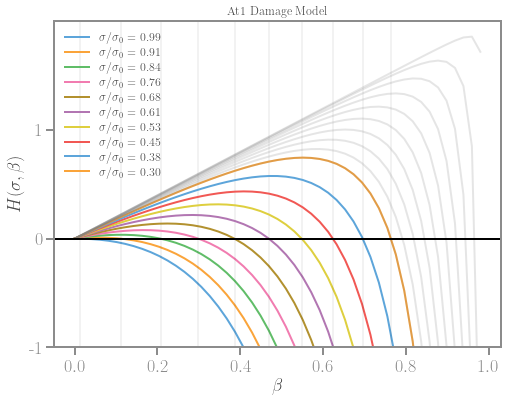

In [254]:
_Hσβ = ana._H_damage_profile().subs(_matpar)

_σ = sp.symbols('σ')
_β = sp.symbols('β')

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for sigmav in np.linspace(.99, .3, 10):
# for sigmav in np.arange(2, 5):
    _Hβ = _Hσβ.subs({_σ: sigmav})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    αmax = _sol[1][0]
    axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = {sigmav:.2f}")
    # axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    axis.axvline(αmax, c='k', lw=.1)

for sigmav in np.linspace(.3, .01, 10):
# for sigmav in np.arange(2, 5):
    _Hβ = _Hσβ.subs({_σ: sigmav})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    αmax = _sol[1][0]
    axis.plot(_damage, [_Hβf(β) for β in _damage], 
        # label = f"$\sigma/\sigma_0$  = {sigmav:.2f}", 
        c='gray',
        alpha = .2
        )
    # axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    # axis.axvline(αmax, c='k', lw=.1)



axis.set_ylabel("$H(\\sigma, \\beta)$")
axis.set_xlabel("$\\beta$")
axis.set_title(f"{ana.model}")
axis.legend()
axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis.set_ylim(-1, 2)


In [255]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-Hbeta.pdf")

In [256]:
ana._s

(1 - α(x))**(-2)

In [257]:
ana._a

(1 - α(x))**2

In [264]:
_subs_sing = {α: _γ*_α0}
_h = (2*ana._w - _σ**2 * (ana._s - 1/E0)).subs(_matpar).subs(_subs_sing)

_h

2*α0*γ - σ**2*(-1 + (-α0*γ + 1)**(-2))

In [259]:
_hprime = sp.diff(_h, _γ)
_hprime

-2*α0*σ**2/(-α0*γ + 1)**3 + 2*α0

(-1.0, 2.0)

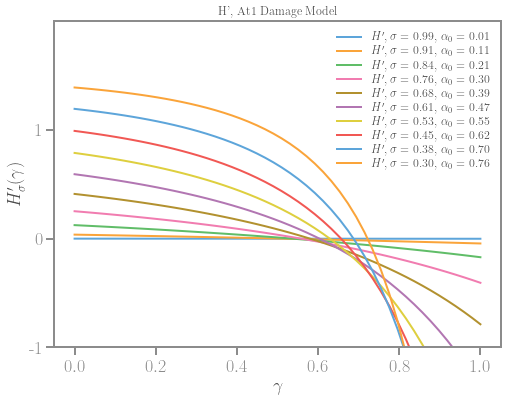

In [260]:
_σ = sp.symbols('σ')
_β = sp.symbols('β')
_Hσβ = ana._H_damage_profile().subs(_matpar)

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for sigmav in np.linspace(.99, .3, 10):
    _Hβ = _Hσβ.subs({_σ: sigmav})

    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 

    αmax = _sol[1][0]
    # print(amax)
    _hprimeS = _hprime.subs({_σ: sigmav, _α0: αmax})
    _hprimeSf = sp.lambdify(_γ, _hprimeS, "numpy")

    # _hprimeSf
    axis.plot(_damage, [_hprimeSf(β) for β in _damage], label = f"$H', \\sigma =$ {sigmav:.2f}, $\\alpha_0 = $ {_sol[1][0]:.2f}")
    # axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    # axis.axvline(αmax, c='k', lw=.1)


axis.set_ylabel("$H'_\\sigma(\\gamma)$")
axis.set_xlabel("$\\gamma$")
axis.set_title(f"H', {ana.model}")
axis.legend()
# axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis.set_ylim(-1, 2)


In [261]:
_h

2*α0*γ - σ**2*(-1 + (-α0*γ + 1)**(-2))

In [262]:
_h**(-1/2)

(2*α0*γ - σ**2*(-1 + (-α0*γ + 1)**(-2)))**(-0.5)

In [263]:
sp.diff(_h, _γ).subs({_γ: 0})

-2*α0*σ**2 + 2*α0

In [265]:
sp.diff(_h, _γ).subs({_γ: 1})

-2*α0*σ**2/(1 - α0)**3 + 2*α0

In [268]:
2*_C*x+-1 +1/(1-_C*x)**2

2*C*x - 1 + (-C*x + 1)**(-2)

                 1     
2⋅C⋅x - 1 + ───────────
                      2
            (-C⋅x + 1) 


<lambdifygenerated-284>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.790569415042095*(x - 0.625 + 0.625/(1 - 0.8*x)**2)**(-0.5)


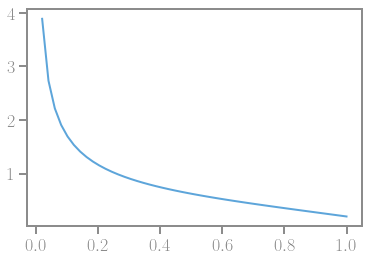

In [276]:
_C = sp.symbols('C', real = True)
_f = 2*_C*x-1+1/(1-_C*x)**2
sp.pprint(_f)
# sp.integrate(_f**(-1/2), x)
sp.integrate(_f**(-1/2), (x, 0, 1))

_ff = sp.lambdify(x, (_f**(-1/2)).subs({_C: .8}), "numpy")

plt.plot(_damage, [_ff(t) for t in _damage], c="C0")


#### Max alpha as a function of sigma

In [458]:
_Hσβ = ana._H_damage_profile() \
    .subs(_matpar)
_Hσβ

2*β - σ**2*(-1 + (1 - β)**(-2))

In [462]:
_subs_sing = {α: _γ*_α0}
_α0


α0

In [459]:
# find index whre arr is positive and less than 1
sol, idx = ana.max_α(_matpar)

sol[idx].simplify()

-σ**2/4 - σ*sqrt(σ**2 + 8)/4 + 1

In [505]:
_H_subs = ana._H_damage_profile().subs(matpar)    \
    .subs({_β: _γ*_α0})                 \
    .subs({_α0: sol[idx]})

_Hσγ = _H_subs.simplify()
_Hσγ.collect(_γ)

γ*(-σ**2/2 - σ*sqrt(σ**2 + 8)/2 + 2) + σ**2 - 16*σ**2/(γ*(σ**2 + σ*sqrt(σ**2 + 8) - 4) + 4)**2

In [503]:
_Hσγ.collect(_γ).subs({_γ: 1})

σ**2/2 - 16*σ**2/(σ**2 + σ*sqrt(σ**2 + 8))**2 - σ*sqrt(σ**2 + 8)/2 + 2

In [496]:
_Hσγ.subs({_σ: .3})

1.52835612040016*γ + 0.09 - 0.09/(1 - 0.764178060200082*γ)**2

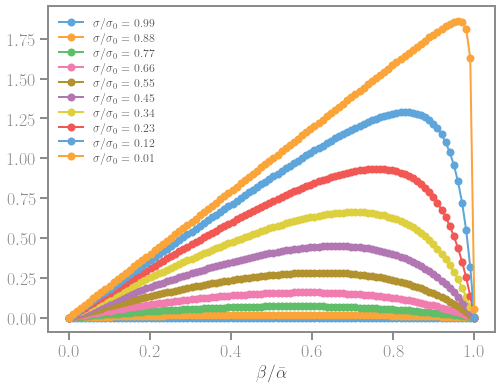

In [484]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))
_tol = 1e-4

_N = 100

for σv in np.linspace(.99, .01, 10):
    _αmax = ana._α_max(σv, _matpar)
    _betas = np.linspace(_tol, 1-_tol, _N)

    _fv = sp.lambdify(_γ, (_Hσγ.subs({_σ: σv})), "numpy")
    axis.plot(_betas, [_fv(b) for b in _betas], marker = 'o', label = f"$\sigma/\sigma_0$  = {σv:.2f}")

# axis.set_ylabel("$\\frac{s(\\beta)-s_0}{\\sqrt{H(\\bar \\sigma, \\beta)}}$")
axis.set_xlabel("$\\beta/\\bar \\alpha$")
# axis.set_ylim(0, 100)
# axis.set_xticks([0, _N], ["0", "1"])
axis.legend()



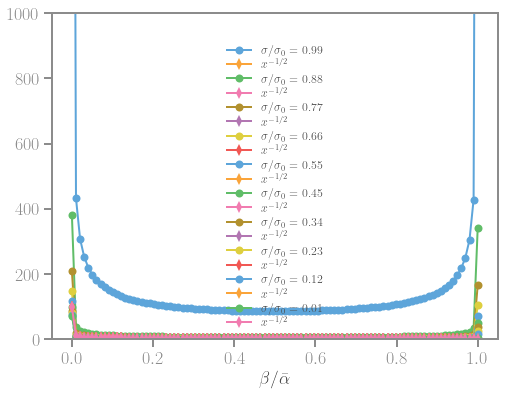

In [491]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))
_tol = 1e-4

_N = 100

for σv in np.linspace(.99, .01, 10):
    _αmax = ana._α_max(σv, _matpar)
    _betas = np.linspace(_tol, 1-_tol, _N)

    _fv = sp.lambdify(_γ, (_Hσγ.subs({_σ: σv})), "numpy")
    axis.plot(_betas, [(_fv(b))**(-1./2.) for b in _betas], marker = 'o', label = f"$\sigma/\sigma_0$  = {σv:.2f}")
    axis.plot(_betas, [(b)**(-1./2.) for b in _betas], marker = 'd', label = "$x^{-1/2}$")

# axis.set_ylabel("$\\frac{s(\\beta)-s_0}{\\sqrt{H(\\bar \\sigma, \\beta)}}$")
axis.set_xlabel("$\\beta/\\bar \\alpha$")
axis.set_ylim(0, 1000)
# axis.set_xticks([0, _N], ["0", "1"])
axis.legend()



In [404]:
_alphamaxs = sp.solve(_Hσβ, _β)
_alphamaxs[1].simplify().subs({_σ: .9})

0.129663006415488

In [281]:
_f = ((ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile()))    \
    .subs(_matpar)                                              \
    .simplify()

_f

(1 - (β - 1)**2)/(sqrt((2*β*(β - 1)**2 + σ**2*((β - 1)**2 - 1))/(β - 1)**2)*(β - 1)**2)

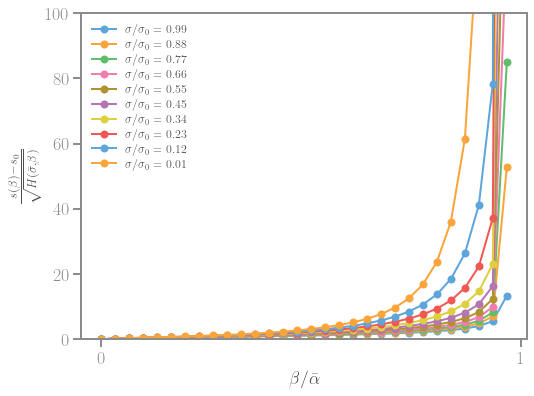

In [282]:
figure, axis = plt.subplots(1, 1, figsize=(8, 6))
_tol = 1e-4


_N = 30
for σv in np.linspace(.99, .01, 10):
#  = .9
    _αmax = ana._α_max(σv, _matpar)
    _betas = np.linspace(_tol, np.float64(_αmax)-_tol, _N)

    _fv = sp.lambdify(_β, _f.subs({_σ: σv}), "numpy")
    axis.plot([_fv(b) for b in _betas], marker = 'o', label = f"$\sigma/\sigma_0$  = {σv:.2f}")

axis.set_ylabel("$\\frac{s(\\beta)-s_0}{\\sqrt{H(\\bar \\sigma, \\beta)}}$")
axis.set_xlabel("$\\beta/\\bar \\alpha$")
axis.set_ylim(0, 100)
axis.set_xticks([0, _N], ["0", "1"])
axis.legend()


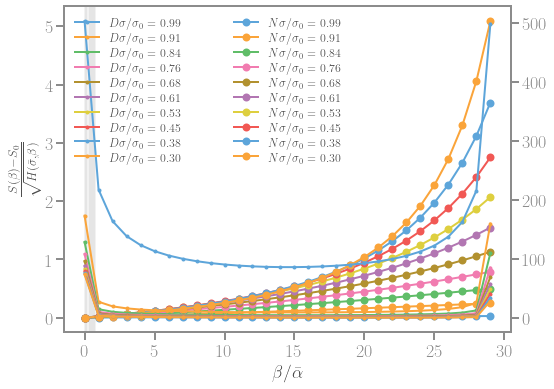

In [283]:
figure, axis = plt.subplots(1, 1, figsize=(8, 6))
_tol = 1e-4

_fsqrth_d = (1/sp.sqrt(ana._H_damage_profile()))    \
    .subs(_matpar)                                              \
    .simplify()

# _fsqrth = (_σ*(ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile()))    \
#     .subs(_matpar)                                              \
#     .simplify()

_fsqrth_n = (_σ*(ana._s - 1/E0).subs(α, _β))    \
    .subs(_matpar)                                              \
    .simplify()

ax_2 = axis.twinx()
_N = 30
for σv in np.linspace(.99, .3, 10):
#  = .9
    _αmax = ana._α_max(σv, _matpar)
    _betas = np.linspace(_tol, np.float64(_αmax)-_tol, _N)

    _fvn = sp.lambdify(_β, _fsqrth_n.subs({_σ: σv}), "numpy")
    _fvd = sp.lambdify(_β, _fsqrth_d.subs({_σ: σv}), "numpy")
    axis.plot([_fvn(b) for b in _betas], marker = 'o', label = f"$N \sigma/\sigma_0$  = {σv:.2f}")
    ax_2.plot([_fvd(b) for b in _betas], marker = '.', label = f"$D \sigma/\sigma_0$  = {σv:.2f}")
    axis.axvline(_αmax, c='k', lw=.1)

axis.set_ylabel("$\\frac{S(\\beta)-S_0}{\\sqrt{H(\\bar \\sigma, \\beta)}}$")
axis.set_xlabel("$\\beta/\\bar \\alpha$")
# axis.set_ylim(0, 100)
# axis.set_xticks([0, _N], ["0", "1"])
axis.legend()
ax_2.legend(loc=2)


In [ ]:
def _eps_1_d(sigma, tol = 1e-3):
    _α_max = ana._α_max(sigma, _matpar)
    _f = (ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile())    \
        .subs(_matpar)                                                   \
        .subs({_σ: σv})                                                   \
        .simplify()

    __fv = sp.lambdify(_β, f.subs(_matpar), "numpy")
    # _tol = 0.001
    _betas = np.linspace(_tol, _α_max-_tol, 30)
    eps = np.trapz([__fv(b) for b in _betas], _betas)

    return eps, (_f, _α_max)

def _eps_1_d_integrand(sigma, matpar, tol = 1e-3):
    _α_max = ana._α_max(sigma, matpar)
    _f = ((ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile()))    \
        .subs(matpar)                                                   \
        .subs({_σ: sigma})                                                   \
        .simplify()

    __fv = sp.lambdify(_β, f.subs(matpar), "numpy")

    return _f, _α_max, __fv




In [284]:
_f = ((ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile()))    \
.subs(matpar)                                                   \
.simplify()                                                 \
.subs({_σ: .9})                                                   \

_f 

__fv = sp.lambdify(_β, _f, "numpy")

_tol = 1e-3
_betas = np.linspace(_tol, amax-_tol, 30)

plt.plot(_betas, [__fv(b) for b in _betas], marker='o')



TypeError: unsupported operand type(s) for -: 'list' and 'float'

In [285]:
_eps_sigma = []
sigmas = np.linspace(1., 0.01, 10)

for sv in sigmas:
    print(f"sv {sv}")
    f, amax, fv = _eps_1_d_integrand(sv, _matpar)
    _tol = 1e-3

    _betas = np.linspace(_tol, amax-_tol, 30)
    [fv(b) for b in _betas]
    # _eps = np.trapz([fv(b) for b in _betas], _betas)
    # _eps_sigma.append(_eps)



sv 1.0


NameError: name '_eps_1_d_integrand' is not defined

#### Behaviour around $\beta=0$

$$\frac{\partial f}{\partial \beta}|_{\beta=0}$$

with $f = 1/\sqrt{H(\sigma, \beta)}$

In [ ]:
sp.diff(_f, _β).simplify().subs({ _β: 0})

Text(0.5, 1.0, 'At1 Damage Model')

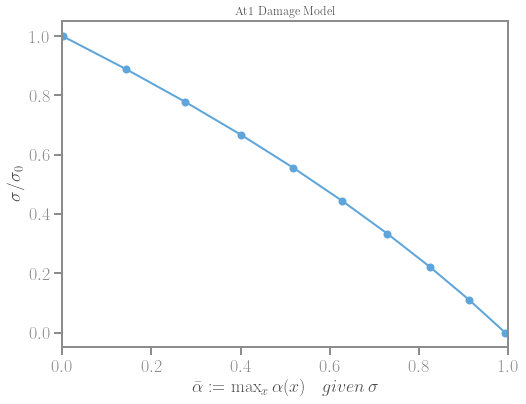

In [286]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))

amax = []
for i in np.linspace(.999, .01, 10):
    amax.append(ana._α_max(i, _matpar))


axis.plot(amax, np.linspace(1, .0, 10), marker='o')
axis.set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
axis.set_ylabel('$\\sigma/\\sigma_0$')
axis.set_xlim(0., 1.)
axis.set_title(f"{ana.model}")

# plt.plot(np.linspace(-.99, -.2, 10), amax)

In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-maxalpha.pdf")

In [287]:
ana.snap_back(matpar) < 0

TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [ ]:
ana._eps_1_d_integrand(.99, _matpar)

sv 0.99 amax 0.013296329263811173
sv 0.9355555555555556 amax 0.08439663569766565
sv 0.8811111111111111 amax 0.1533397246087211
sv 0.8266666666666667 amax 0.22015907519920755
sv 0.7722222222222223 amax 0.28488909367020526
sv 0.7177777777777778 amax 0.347565088934857
sv 0.6633333333333333 amax 0.40822324339565397
sv 0.6088888888888889 amax 0.4669005787212792
sv 0.5544444444444445 amax 0.523634916611026
sv 0.5 amax 0.5784648345913732


[0.015741264829317553,
 0.14304575152842547,
 0.29234359624758305,
 0.46289738671057135,
 0.6575415897238038,
 0.8808297046945164,
 1.1392649655793858,
 1.4420141968692655,
 1.8021672212755386,
 2.238897644800646]

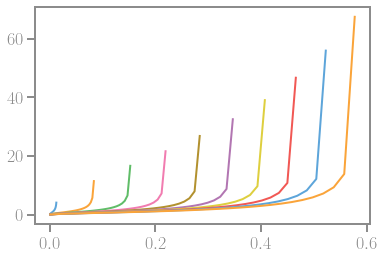

In [288]:
_eps_sigma = []
sigmas = np.linspace(.99, 0.5, 10)

for sv in sigmas:
    f, amax, fv = ana._eps_1_d_integrand(sv, _matpar)
    print(f"sv {sv} amax {amax}")
    _tol = 1e-3

    _betas = np.linspace(_tol, amax-_tol, 30)
    [fv(b) for b in _betas]
    plt.plot(_betas, [fv(b) for b in _betas])
    _eps = np.trapz([fv(b) for b in _betas], _betas)
    _eps_sigma.append(_eps)

_eps_sigma


<lambdifygenerated-325>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(1 - (β - 1)**2)/(sqrt(((β - 1)**2*(β + 0.125) - 0.125)/(β - 1)**2)*(β - 1)**2)
<lambdifygenerated-325>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(1 - (β - 1)**2)/(sqrt(((β - 1)**2*(β + 0.125) - 0.125)/(β - 1)**2)*(β - 1)**2)
<lambdifygenerated-325>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(1 - (β - 1)**2)/(sqrt(((β - 1)**2*(β + 0.125) - 0.125)/(β - 1)**2)*(β - 1)**2)


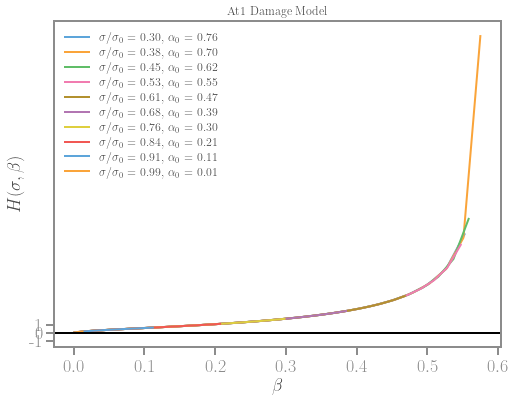

In [290]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for sigmav in np.linspace(.99, .3, 10)[::-1]:
# for sigmav in np.arange(2, 5):
    # _Hβ = _Hσβ.subs({_σ: sigmav})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    # _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    # _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    # αmax = _sol[1][0]
    
    amax = ana._α_max(sigmav, _matpar)
    _betas = np.linspace(_tol, amax-_tol, 30)
    # print(_betas)
    # axis.plot(_betas, _betas, label = f"$\sigma/\sigma_0$  = {sigmav:.2f}, amax = {amax:.2f}")
    axis.plot(_betas, [fv(β) for β in _betas], label = f"$\sigma/\sigma_0$  = {sigmav:.2f}, $\\alpha_0$ = {amax:.2f}")
    # axis.axvline(αmax, c='k', lw=.1)

# for sigmav in np.linspace(.3, .01, 10):
#     amax = ana._α_max(sigmav, _matpar)
#     _betas = np.linspace(_tol, amax-_tol, 30)

#     axis.plot(_betas, [fv(β) for β in _betas], 
#         c='gray',
#         alpha = .2
#         )



axis.set_ylabel("$H(\\sigma, \\beta)$")
axis.set_xlabel("$\\beta$")
axis.set_title(f"{ana.model}")
axis.legend()
axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
# axis.set_ylim(-1, 2)


In [378]:
def _analyse_H(analysis, matpar = {}):
    fig, ax = _plot_H(analysis)
    fig.tight_layout()
    _fname = f"../../notes/figures/{analysis.model.slug}-Hbeta.pdf"
    fig.savefig(_fname)

    print(f"H Figure in {_fname}")

    fig, ax = _plot_Hprime(analysis)
    fig.tight_layout()
    _fname = f"../../notes/figures/{analysis.model.slug}-H-prime-beta.pdf"
    fig.savefig(_fname)

    print(f"H-prime Figure in {_fname}")

    _subs_sing = {_β: _γ*_α0}
    h = analysis._H_damage_profile().subs(_matpar).subs(_subs_sing)
    hprime = sp.diff(h, _γ)
    hprime_zero = hprime.subs({_γ: 0})
    hprime_one = hprime.subs({_γ: 1})
    # sp.latex(h)

    if matpar == {}:
        _fname = f"H-{analysis.model.slug}.txt"
    else: 
        _fname = f"H-{analysis.model.slug}-matpar.txt"
    print(f"Output in {_fname}")
    
    _fcs = [h,
            hprime,
            hprime_zero,
            hprime_one
            ]
    _lab = ["H", "Hprime", "Hprime-zero", "Hprime-one"]
    _known = ["H_\\sigma(, \\gamma)=", 
              "H'_\\sigma(\\gamma)=",
              "H'_\\sigma(\\gamma)(0)=",
              "H'_\\sigma(\\gamma)(1)=",
              ]
    out_file = open(_fname,"w")
    
    for y in zip(_fcs, _lab, _known):
        _tex = y[2] + str(sp.latex(y[0])) \
            .replace("α", "\\alpha") \
            .replace("β", "\\beta") \
            .replace("γ", "\\gamma") \
            .replace("σ", "\\sigma")
        out_file.write("\\begin{equation}")
        out_file.write(f"\\label{{ eqn:{analysis.model.slug}-{y[1]} }}")
        out_file.write(_tex)
        out_file.write("\\end{equation}")
        out_file.write("\n")

    out_file.close()

    return


def _plot_H(analysis):
    _Hσβ = analysis._H_damage_profile().subs(_matpar)
    _σ = sp.symbols('σ')
    _β = sp.symbols('β')

    figure, axis = plt.subplots(1, 1, figsize=(8, 6))

    for sigmav in np.linspace(.99, .3, 10):
        _Hβ = _Hσβ.subs({_σ: sigmav})
        _Hβf = sp.lambdify(_β, _Hβ, "numpy")
        _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
        αmax = _sol[1][0]
        axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = {sigmav:.2f}")
        axis.axvline(αmax, c='k', lw=.1)

    for sigmav in np.linspace(.3, .01, 10):
        _Hβ = _Hσβ.subs({_σ: sigmav})
        _Hβf = sp.lambdify(_β, _Hβ, "numpy")
        _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
        αmax = _sol[1][0]
        axis.plot(_damage, [_Hβf(β) for β in _damage], 
            c='gray',
            alpha = .2
            )

    axis.set_ylabel("$H(\\sigma, \\beta)$")
    axis.set_xlabel("$\\beta$")
    axis.set_title(f"{analysis.model}")
    axis.legend()
    axis.axhline(0, c="k")
    axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
    axis.set_ylim(-1, 2)

    return figure, axis


def _plot_Hprime(analysis):
    _σ = sp.symbols('σ')
    _β = sp.symbols('β')
    _Hσβ = analysis._H_damage_profile().subs(_matpar)

    figure, axis = plt.subplots(1, 1, figsize=(8, 6))

    for sigmav in np.linspace(.99, .3, 10):
        _Hβ = _Hσβ.subs({_σ: sigmav})

        _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 

        αmax = _sol[1][0]
        _hprimeS = _hprime.subs({_σ: sigmav, _α0: αmax})
        _hprimeSf = sp.lambdify(_γ, _hprimeS, "numpy")

        axis.plot(_damage, [_hprimeSf(β) for β in _damage], label = f"$H', \\sigma =$ {sigmav:.2f}, $\\alpha_0 = $ {_sol[1][0]:.2f}")

    axis.set_ylabel("$H'_\\sigma(\\gamma)$")
    axis.set_xlabel("$\\gamma$")
    axis.set_title(f"H', {analysis.model}")
    axis.legend()
    axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
    axis.set_ylim(-1, 2)

    return figure, axis



<lambdifygenerated-1071>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.9801 - 0.9801/(1 - β)**2
<lambdifygenerated-1072>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.834177777777778 - 0.834177777777778/(1 - β)**2
<lambdifygenerated-1073>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.700011111111111 - 0.700011111111111/(1 - β)**2
<lambdifygenerated-1074>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.5776 - 0.5776/(1 - β)**2
<lambdifygenerated-1075>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.466944444444444 - 0.466944444444444/(1 - β)**2
<lambdifygenerated-1076>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.368044444444444 - 0.368044444444444/(1 - β)**2
<lambdifygenerated-1077>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.2809 - 0.2809/(1 - β

H Figure in ../../notes/figures/at1-Hbeta.pdf
H-prime Figure in ../../notes/figures/at1-H-prime-beta.pdf
Output in H-at1.txt


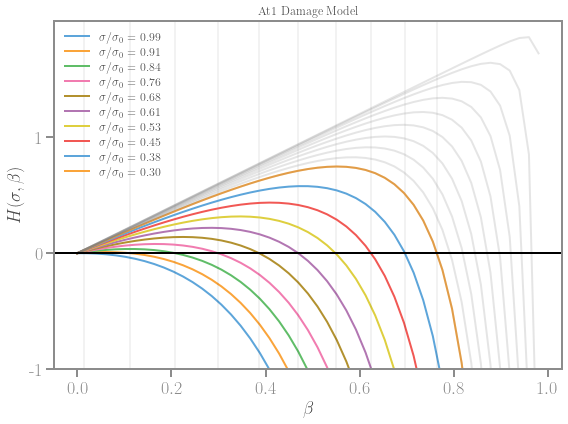

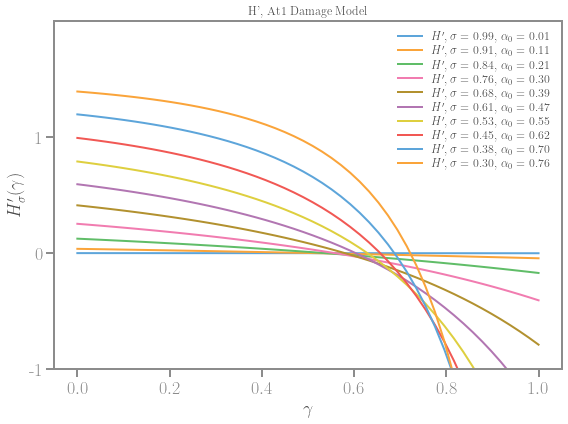

In [379]:
# %%capture
_analyse_H(ana)

In [382]:
%%capture

state = {u: u, α: α}

# ATK
_matpar = {k: 2, E0: 1, w1: 1, 𝓁:𝓁, L: 1}
matpar = {k: k, E0: E0, w1: w1, 𝓁:𝓁, L: L}

atk = DefaultDamage(state, matpar, slug=f"atk")
ana_atk = ModelAnalysis(atk)
ana_atk.criterion()
_analyse_H(ana_atk)

# ATN

matpar = {n: 1, E0: 1, w1: 1, 𝓁:𝓁}
_matpar = {n: 1, L: 1, E0: 1, w1: 1, 𝓁:𝓁}

at1 = DamageATn(state, matpar={n: 1, E0: E0, w1: w1, 𝓁:𝓁, L: L},
                name="At1 Damage Model",
                slug=f"at1")
ana_at1 = ModelAnalysis(model = at1)
ana_at1.criterion()
_analyse_H(ana_at1)

# PQ

p, q, E0, L, w1, 𝓁, σc = sp.symbols('p q E0 L w1 𝓁 σc')

matpar = {p: p, q: q, E0: E0, L: L, w1: w1, 𝓁:𝓁, σc: σc}
_matpar = {p: 1, q: 1, E0: 1, L: 1, w1: 2, 𝓁:𝓁, σc: 1}

dpq = DamagePQ(state, matpar=matpar,
               name="PQ Damage Model",
               slug = "pq")
ana_pq = ModelAnalysis(model = dpq)
ana_pq.criterion()
_analyse_H(ana_pq)


# for damage_class in [ana_atk, ana_at1]:
#     damage_class.criterion()
#     print(damage_class.model.slug)
#     _analyse_H(damage_class)


In [381]:
ana._H_damage_profile()

(2*β - σ**2*((1 - β)**(-2) - 1/E0))/E0

## PQ

In [ ]:
state = {u: u, α: α}
p, q, E0, L, w1, 𝓁, σc = sp.symbols('p q E0 L w1 𝓁 σc')

matpar = {p: p, q: q, E0: E0, L: L, w1: w1, 𝓁:𝓁, σc: σc}
_matpar = {p: 1, q: 1, E0: 1, L: 1, w1: 2, 𝓁:𝓁, σc: 1}
# _matpar = {n: 1, L: 1, E0: 1, w1: 1, 𝓁:𝓁}

dpq = DamagePQ(state, matpar=matpar, name="PQ Damage Model", slug = "pq")
ana = ModelAnalysis(model = dpq)
_ = ana.criterion().simplify()
_

In [ ]:
ana._print_model_functions()
ana._print_model_functions(_matpar)

In [ ]:
_ = ana.model.energy(ana.model.state)
_

In [ ]:
sp.latex(_)

In [ ]:
_ = ana.criterion()
_

In [ ]:
sp.latex(_)

In [ ]:
[np.float(t.subs(_matpar).subs({L: 1})) for t in sp.solve(ana.crit, t)]

In [ ]:
ana._critical_load

In [ ]:
ana.critical_load_N(_matpar)

In [ ]:
_ = ana.model.energy(ana.model.state)
# , α) \
#     .subs({u: _u0, α: _alpha0})         \
#     .simplify()

In [ ]:
sp.latex(_)

In [ ]:
_eq = sp.diff(dpq.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

In [ ]:
# _ = _eq.subs(_matpar).subs({p: 2, q: 1}).simplify()
_ = _eq.subs(_matpar).simplify()

In [ ]:
_ = ana._homogeneous_alpha(_matpar)[1]
_

In [ ]:
ana.crit
ana.critical_load()

In [ ]:
tc = ana.critical_load().subs(_matpar)


In [ ]:
state, (_uf, _af) = ana._homogeneous_state(ah = ana._homogeneous_alpha(_matpar)[1])

In [ ]:
_a = state[α]

_ah_f = sp.lambdify(t, _a.subs(_matpar), "numpy")
_ah_f(0)

In [ ]:
print(ana.model)

In [ ]:
figure, axis = plt.subplots(1, 1, figsize=(8, 6))

axis.plot(_times, [_ah_f(t) for t in _times])
tc = ana.critical_load().subs(_matpar)

# axis.axhline(0, c='k')
axis.set_xlim(0, 3)
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$\\alpha$")
axis.set_ylabel("$\\alpha$")
axis.set_title(f"{ana.model}")


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-alpha-homog.pdf")

In [ ]:
ana._s.subs(_matpar)

In [ ]:
figure, axis = ana.plot_material(_matpar)

In [ ]:
dpq.energy({u: _homog_state[u], α: _homog_state[α]})

In [ ]:
ana._deps_1_d_dσ()

In [ ]:
ana._deps_1_d_dσ() \
    .subs({E0: 1, σc: 1})

## Playground

In [439]:
%%capture

state = {u: u, α: α}

# ATK
atk_matpar = {k: 2, E0: 1, w1: 1, 𝓁:𝓁, L: 1}
matpar = {k: k, E0: E0, w1: w1, 𝓁:𝓁, L: L}

atk = DefaultDamage(state, matpar, slug=f"atk")
ana_atk = ModelAnalysis(atk)
ana_atk.criterion()
# _analyse_H(ana_atk)

# ATN

matpar = {n: 1, E0: 1, w1: 1, 𝓁:𝓁}
at1_matpar = {n: 1, L: 1, E0: 1, w1: 1, 𝓁:𝓁}

at1 = DamageATn(state, matpar={n: 1, E0: E0, w1: w1, 𝓁:𝓁, L: L},
                name="At1 Damage Model",
                slug=f"at1")
ana_at1 = ModelAnalysis(model = at1)
ana_at1.criterion()
# _analyse_H(ana_at1)

# PQ

p, q, E0, L, w1, 𝓁, σc = sp.symbols('p q E0 L w1 𝓁 σc')

matpar = {p: p, q: q, E0: E0, L: L, w1: w1, 𝓁:𝓁, σc: σc}
pq_matpar = {p: 1, q: 1, E0: 1, L: 1, w1: 2, 𝓁:𝓁, σc: 1}

dpq = DamagePQ(state, matpar=matpar,
               name="PQ Damage Model",
               slug = "pq")
ana_pq = ModelAnalysis(model = dpq)
ana_pq.criterion()
# _analyse_H(ana_pq)






# -----------




In [534]:
state = {u: u, α: α}

# ATK
atk_matpar = {k: 2, E0: 1, w1: 1, 𝓁:𝓁, L: 1}
matpar = {k: k, E0: E0, w1: w1, 𝓁:𝓁, L: L}

atk = DefaultDamage(state, matpar, slug=f"atk")
ana_atk = ModelAnalysis(atk)

# ATN

matpar = {n: 1, E0: 1, w1: 1, 𝓁:𝓁}
at1_matpar = {n: 1, L: 1, E0: 1, w1: 1, 𝓁:𝓁}

at1 = DamageATn(state, matpar={n: 1, E0: E0, w1: w1, 𝓁:𝓁, L: L},
                name="At1 Damage Model",
                slug=f"at1")
ana_at1 = ModelAnalysis(model = at1)

# PQ

p, q, E0, L, w1, 𝓁, σc = sp.symbols('p q E0 L w1 𝓁 σc')

matpar = {p: p, q: q, E0: E0, L: L, w1: w1, 𝓁:𝓁, σc: σc}
pq_matpar = {p: 1, q: 1, E0: 1, L: 1, w1: 2, 𝓁:𝓁, σc: 1}

dpq = DamagePQ(state, matpar=matpar,
               name="PQ Damage Model",
               slug = "pq")
ana_pq = ModelAnalysis(model = dpq)


model_list = [ana_atk, ana_at1, ana_pq]
parameters_list = [atk_matpar, at1_matpar, pq_matpar]

sols = []
labs = []
knowns = [] 

for case, parameters in zip(model_list, parameters_list):
    # print(case.model.slug, parameters)
    print(case.model.slug)
    print()
    case.criterion()
    # sp.print_latex(case.crit)
    # _analyse_H()
    # sp.print_latex(case.max_α(parameters))
    sol, idx = case.max_α(parameters)
    print(sol[idx])
    sols.append(sol[idx])
    labs.append(f"{case.model.slug}-alpha-max")
    knowns.append("\\bar \\alpha=") 


_fname = f"alpha-max-models.txt"

out_file = open(_fname,"w")

for y in zip(sols, labs, knowns):
    # print(str(sp.latex(y[0])))
    _tex = y[2] + str(sp.latex(y[0])) \
        .replace("α", "\\alpha") \
        .replace("β", "\\beta") \
        .replace("γ", "\\gamma") \
        .replace("σ", "\\sigma")
    print(_tex)
    out_file.write("\\begin{equation}")
    out_file.write(f"\\label{{ eqn:{y[1]} }}")
    out_file.write(_tex)
    out_file.write("\\end{equation}")
    out_file.write("\n")

# -----------
# print( sols, labs, knowns)



atk

1 - σ**2
at1

-σ*sqrt(σ**2 + 8)/4 - (σ - 2)*(σ + 2)/4
pq

1 - σ**2/2
\bar \alpha=1 - \sigma^{2}
\bar \alpha=- \frac{\sigma \sqrt{\sigma^{2} + 8}}{4} - \frac{\left(\sigma - 2\right) \left(\sigma + 2\right)}{4}
\bar \alpha=1 - \frac{\sigma^{2}}{2}


In [441]:
# ana_atk.max_α(atk_matpar)
# ana_at1.max_α(at1_matpar)
ana_pq.max_α(pq_matpar)


([0, 1 - σ**2/2], 1)

ATk

In [ ]:


state = {u: u, α: α}
_matpar = {k: 2, E0: 1, w1: 1, 𝓁:𝓁, L: 1}
matpar = {k: k, E0: 1, w1: w1, 𝓁:𝓁, L: L}

_u0 = t*x/L
_alpha0 = 0 

atk = DefaultDamage(state, _matpar)


ana = ModelAnalysis(atk)
_crit = sp.diff(atk.energy(state), α).subs({u: _u0, α: _alpha0}).simplify()
_crit

# atk = DefaultDamage(state, matpar)
ana = ModelAnalysis(atk)
ana.criterion()
ana.set_critical_load(ana.critical_load_N(_matpar)[0][0])
# ana._critical_load
ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])


In [ ]:

fig, ax = ana.plot_homogeneous_alpha(_matpar)
ax.set_ylim(-0.1, 1.2)
ax.set_xlim(0, _matpar[k])


In [ ]:
_stress = ana._stress(ah = ana._homogeneous_alpha()[1]).simplify()


In [ ]:
_stress.subs(ana.model.matpar)

In [ ]:
_sh_f = sp.lambdify(t, _stress.subs(ana.model.matpar), "numpy")
plt.plot(_times, [_sh_f(t) for t in _times])
plt.xlim(0, _matpar[k])



In [ ]:
_matpar = {p: 1, q: 3, E0: 1, L: 1, w1: 2, 𝓁:𝓁, σc: 1}

figure, axis = ana.plot_material(_matpar)
axis[1].set_ylim(0, 20)

In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-13-model.pdf")

In [ ]:
_Hσβ = ana._H_damage_profile().subs(_matpar)

_σ = sp.symbols('σ')
_β = sp.symbols('β')

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for k in np.linspace(.99, .2, 10):
# for k in np.arange(2, 5):
    _Hβ = _Hσβ.subs({_σ: k})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    αmax = _sol[1][0]
    axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = {k:.2f}")
    # axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    axis.axvline(αmax, c='k', lw=.1)



axis.set_ylabel("$H(\\sigma, \\beta)$")
axis.set_xlabel("$\\beta$")
axis.set_title(f"{ana.model}")
axis.legend()
axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis.set_ylim(-1, 1)


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-Hbeta.pdf")

In [ ]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))

amax = []
for i in np.linspace(.999, .01, 10):
    amax.append(ana._α_max(i, _matpar))


axis.plot(amax, np.linspace(1, .0, 10), marker='o')
axis.set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
axis.set_ylabel('$\\sigma/\\sigma_0$')
axis.set_xlim(0., 1.)
axis.set_title(f"{ana.model}")


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-maxalpha.pdf")

In [ ]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


_en_h = sp.lambdify(t, at1.energy(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")

axis.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0", label = "total")
axis.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1", label = "damage")
axis.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2", label = "elastic")
axis.axvline(np.float64(tc), c='k', lw=.1)
axis.legend()


axis.set_ylim(-0.1, 2.1)
axis.set_xticks([0, tc, 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$t$")
axis.set_ylabel("$E$")
axis.set_title(f"{ana.model}")


In [ ]:
figure.tight_layout()
figure.savefig("../../notes/figures/pq-energies-homog.pdf")

In [ ]:
_σ = sp.symbols('σ')
_β = sp.symbols('β')
sigmav = .8

_f = ((ana._s - 1/E0).subs({α: _β}) * 1/sp.sqrt(ana._H_damage_profile()))    \
    .subs(ana.model.matpar)                                                \
    .subs({_σ: sigmav, 𝓁: .1})
_fvβ = sp.lambdify(_β, _f, "numpy")


# _α_max = ana._α_max(sigmav)
# 
# print(_α_max.subs(ana.model.matpar))

_x = np.linspace(0.1, .3)
_fvβ(_x)
plt.plot(_fvβ(_x), _x, marker='o')


# np

PQ

In [ ]:
p, q, E0, L, w1, 𝓁, σc = sp.symbols('p q E0 L w1 𝓁 σc')


state = {u: u, α: α}
_matpar = {k: 2, E0: 1, w1: 1, 𝓁:𝓁, L: 1, p: 2, q: 2, σc: 1}
matpar = {k: k, E0: 1, w1: w1, 𝓁:𝓁, L: L}

_u0 = t*x/L
_alpha0 = 0 

dpq = DamagePQ(state, matpar={}, name="pq")


ana = ModelAnalysis(dpq)
_crit = sp.diff(dpq.energy(state), α).subs({u: _u0, α: _alpha0}).simplify()
_crit

# dpq = DefaultDamage(state, matpar)
ana = ModelAnalysis(dpq)
ana.criterion()
# ana.set_critical_load(ana.critical_load_N(_matpar)[0][0])
# ana._critical_load
# ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])


In [ ]:
sp.solve(ana.crit, t**2)

In [ ]:
ana.crit

In [ ]:
sp.solve(ana.crit, t**2)

In [ ]:
sp.solve(ana.crit, t**2)

In [ ]:
ana.model._matpar

In [ ]:
_eq = sp.diff(ana.model.energy(state), α) \
                .subs({u: _u0, α: α})         \
                .simplify().subs(_matpar)

_ah = sp.solve(_eq, α)

In [ ]:
ana._homogeneous_alpha(matpar = _matpar)

In [ ]:
_u0

In [ ]:
_eq = sp.diff(dpq.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify().subs(_matpar)

_ah = sp.solve(_eq, α)


_ah_f = [sp.lambdify(t, a.subs(_matpar), "numpy") for a in _ah]

# _ahp = sp.lambdify(t, _ah_sub[0].subs(_matpar), "numpy")

_times = np.linspace(0., 3)

for _i, _a in enumerate(_ah_f):
    plt.plot(_times, [_a(t) for t in _times], label=_i)
plt.legend()

plt.axhline(0, c='k')
plt.xlim(0, _matpar[k])
# plt.plot()

In [ ]:
ana._homogeneous_state(ah = ana._homogeneous_alpha(matpar = _matpar)[0])


In [ ]:
ana.critical_load_N(_matpar)[0][0]

In [ ]:
ana.critical_load()

In [ ]:

def plot_H_(matpar):
    """docstring for plot_H_"""
        
    _Hσβ = ana._H_damage_profile().subs(matpar)


    _σ = sp.symbols('σ')
    _β = sp.symbols('β')

    figure, axis = plt.subplots(1, 1, figsize=(8, 6))


    for sigmav in np.linspace(.99, .3, 10):
        _Hβ = _Hσβ.subs({_σ: sigmav})
        _Hβf = sp.lambdify(_β, _Hβ, "numpy")
        _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
        αmax = _sol[1][0]
        axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = {sigmav:.2f}")
        axis.axvline(αmax, c='k', lw=.1)

    for sigmav in np.linspace(.3, .01, 10):
        _Hβ = _Hσβ.subs({_σ: sigmav})
        _Hβf = sp.lambdify(_β, _Hβ, "numpy")
        _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
        αmax = _sol[1][0]
        axis.plot(_damage, [_Hβf(β) for β in _damage], 
            c='gray',
            alpha = .2
            )


    axis.set_ylabel("$H(\\sigma, \\beta)$")
    axis.set_xlabel("$\\beta$")
    axis.set_title(f"{ana.model}")
    axis.legend()
    axis.axhline(0, c="k")
    axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
    axis.set_ylim(-1, 2)
    
    return figure, axis

def plot_max_alpha(matpar):
    """docstring for plot_max_alpha"""
    figure, axis = plt.subplots(1, 1, figsize=(8, 6))

    amax = []
    for i in np.linspace(.99, .01, 10):
        amax.append(ana._α_max(i, matpar))

    axis.plot(amax, np.linspace(1, .0, 10), marker='o')
    axis.set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
    axis.set_ylabel('$\\sigma/\\sigma_0$')
    axis.set_xlim(0., 1.)
    axis.set_title(f"{ana.model}")
    
    return figure, axis


### Generic analysis

In [ ]:
print(ana.model)

In [ ]:
_α0 = sp.symbols('α0')
_γ = sp.symbols('γ')

_Hσβ_α0 = ana._H_damage_profile().subs(_matpar).subs({_β: _α0*_γ})
_Hσβ_α0


In [ ]:
plot_H_(_matpar)

In [ ]:
plot_max_alpha(_matpar)

In [ ]:
_α0 = sp.symbols('α0')

figure, axis = plt.subplots(1, 1, figsize=(8, 6))
_tol = 1e-4

_fsqrth_d = (1/sp.sqrt(ana._H_damage_profile()))    \
    .subs(_matpar)                                              \
    .simplify()

# _fsqrth = (_σ*(ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile()))    \
#     .subs(_matpar)                                              \
#     .simplify()

_fsqrth_n = (_σ*(ana._s - 1/E0).subs(α, _α0*_β))    \
    .subs(_matpar)                                              \
    .simplify()

ax_2 = axis.twinx()
_N = 30
for σv in np.linspace(.99, .1, 10):
#  = .9
    _αmax = ana._α_max(σv, _matpar)
    # _betas = np.linspace(_tol, np.float64(_αmax)-_tol, _N)
    _betas = np.linspace(_tol, 1.-_tol, _N)

    _fvn = sp.lambdify(_β, _fsqrth_n.subs({_σ: σv, _α0: _αmax}), "numpy")
    _fvd = sp.lambdify(_β, _fsqrth_d.subs({_σ: σv, _α0: _αmax}), "numpy")
    # axis.plot(_betas, [_fvn(b) for b in _betas], marker = 'o', label = f"$N \sigma/\sigma_0$  = {σv:.2f}")
    ax_2.plot(_betas, [_fvd(b) for b in _betas], marker = '.', label = f"$D \sigma/\sigma_0$  = {σv:.2f}")
    # axis.axvline(_αmax, c='k', lw=.1)

axis.set_ylabel("$\\frac{S(\\beta)-S_0}{\\sqrt{H(\\bar \\sigma, \\beta)}}$")
axis.set_xlabel("$\\beta/\\bar \\alpha$")
# axis.set_ylim(0, 100)
# axis.set_xticks([0, _N], ["0", "1"])
axis.legend()
axis.set_title(f"{ana.model}")

ax_2.legend(loc=1)


# Discrete

The Energy
$$
E(u):=\frac{1}{2} NE_0\sum_{i=1}^N a(\alpha_i)(u_{i}-u_{i-1})^2 + \frac{w_1}{N} \sum_{i=1}^N w(\alpha_i)
$$

In [ ]:

def _print_discrete_model_functions(analysis, matpar = {}):
    if matpar == {}:
        _fname = f"model-{analysis.model.slug}.txt"
    else: 
        _fname = f"model-{analysis.model.slug}-matpar.txt"
    print(f"Output in {_fname}")

    # sp.latex(analysis._a)
    # sp.latex(analysis._ap)
    # sp.latex(analysis._app)
    # sp.latex(analysis._s)
    # sp.latex(analysis._sp)
    # sp.latex(analysis._spp)
    
    # _fcs = [analysis._a.subs(matpar), 
    #     analysis._ap.subs(matpar), 
    #     analysis._app.subs(matpar), 
    #     analysis._s.subs(matpar), 
    #     analysis._sp.subs(matpar), 
    #     analysis._spp.subs(matpar)]
    # _lab = ["a", "aprime", "apprime", "s", "sprime", "spprime"]
    # _known = ["a(\\alpha)=", "a'(\\alpha)=", "a''(\\alpha)=", 
    #         "s(\\alpha)=", "s'(\\alpha)=", "s''(\\alpha)="]

    # out_file = open(_fname,"w")
    
    # for y in zip(_fcs, _lab, _known):
    #     _tex = y[2] + str(sp.latex(y[0])).replace("α", "\\alpha")
    #     out_file.write("\\begin{equation}")
    #     out_file.write(f"\\label{{ eqn:{analysis.model.slug}-{y[1]} }}")
    #     out_file.write(_tex)
    #     out_file.write("\\end{equation}")
    #     out_file.write("\n")

    # out_file.close()

    # _σ = sp.symbols('σ')
    # _β = sp.symbols('β')
    # _α0 = sp.symbols('α0')
    # _γ = sp.symbols('γ')
    # _E0 = analysis.model.matpar[E0]

    # _fch = analysis._H_damage_profile()

    # fc0 = analysis.criterion()
    # fc1 = analysis.critical_load()
    # fc3 = _fch.subs(matpar).subs({_β: -_γ/_α0+1})
    # fc4 = (1/sp.sqrt(
    #         _fch.subs(matpar))
    #         ).simplify()
    # fc5 = ((analysis._s - 1/E0).subs(α, _β)/sp.sqrt(_fch))    \
    #     .subs(matpar)                                              \
    #     .simplify()

    # fc6 = (((analysis._s - 1/E0).subs(α, _β)/sp.sqrt(_fch)))    \
    #     .subs(matpar).subs({_β: -_γ/_α0+1})                \
    #     # .simplify()
    
    # fc7 = _fch.subs(matpar).subs({_β: -_γ/_α0+1})
    # fc7_γ = sp.diff(fc7, _γ).subs({_γ: 1}).simplify()
    # # Hσγ_γ.simplify()
    # fc6_γ = sp.diff(fc6, _γ).subs({_γ: 1}).subs(matpar).simplify()
    _α = sp.symbols("a_h")
    _eh = sp.symbols("e_h") 


    _subs_αh = {a: _α for a in α}
    _subs_eh = {e: _eh for e in state["e"]}

    eq0 =  sp.diff(analysis.model.energy(state), α[0]).subs({α[0]: _α})
    fc0 = datk.energy(state).subs(_subs_eh).subs(_subs_αh)


    _fcs = [fc0, fc1, _fch, 
            # fc2, 
            fc3, fc4, fc5, fc6, fc7, fc7_γ, fc6_γ]
    _lab = ["crit", "Ehomog", "Hsigmabeta", 
            # "Hsigmagamma", 
            "Hsigmabeta_mat", "one_over_H",
            "eps_integrand", 
            "eps_integrand_gamma", 
            "deriv_integrand_gamma", 
            "deriv_integrand_gamma_one", 
            "deriv_integrand_gamma_one", 
            ]
    _known = ["0=", "t_c=", 
            "E_h(\\alpha, e)=", 
            # "H(\\sigma, \\beta)=",
            "H(\\sigma, \\gamma)=",
            "1/\\sqrt{H(\\sigma, \\beta)}=",
            "(S(\\beta)-S_0)/\\sqrt{H(\\sigma, \\beta)}=",
            "(S(\\gamma)-S_0)/\\sqrt{H(\\sigma, \\gamma)}=",
            "\\frac{\\partial H}{\\partial \\gamma}=",
            "\\frac{\\partial H}{\\partial \\gamma}|_{\\gamma=1}=",
            "\\frac{\\partial 1/\\sqrt{H}}{\\partial \\gamma}|_{\\gamma=1}="
            ]

    out_file = open(_fname,"a")
    out_file.write("\n")
    
    for y in zip(_fcs, _lab, _known):
        print(y[2])
        _tex = y[2] + str(sp.latex(y[0])).replace("α", "\\alpha") \
                                .replace("σ", "\\sigma")    \
                                .replace("β", "\\beta")    \
                                .replace("γ", "\\gamma")    
        out_file.write("\\begin{equation}")
        out_file.write(f"\\label{{ eqn:{analysis.model.slug}-{y[1]} }}")
        out_file.write(_tex)
        out_file.write("\\end{equation}")
        out_file.write("\n")

    out_file.close()


In [ ]:
def _critical_load(matpar):
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]
    return np.sqrt(8*_w1 / (_mu*_k)/4)
    # independent of _N**2

def a_atk(alpha):
    return (1 - alpha) / ((_k-1) * alpha + 1)

def s_atk(alpha):
    return 1/a_atk(alpha)

def _homogeneous_state(t, matpar):
    """docstring for _homogeneous_state"""
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]


    # _tc = np.sqrt(matpar/k)
    # _a = (tau - 1) / (_k - 1)

    _tc = _critical_load(params["model"])
    _uh = [0 for i in range(0, _N+1)]
    
    if t <= _tc:
        # elastic
        _alphah = [0. for i in range(0, _N)]
        _uh = [i*t/_N for i in range(0, _N+1)]
    else:   
        # damaging
        _α = (t/_tc - 1) / (_k - 1)
        _alphah = [_α for i in range(0, _N)]

        # _S = reduce(lambda a, b: a+b, list(map(a_atk, _alphah)))
        
        _S = _N*a_atk(_α)

        _e = t / _N
        for i in range(0, _N+1):
            if i == 0:
                _uh[i] = 0
            else: 
                _uh[i] = _e * i
        # _uh = [a_atk(_α) / (_N*a_atk(_α)) * i/_N for i in range(0, _N+1)]
        # print(t, _e)
    return _alphah, _uh

In [ ]:
class DiscreteDamage():
    def __init__(self, state, matpar, name = "discrete atk", slug = "atk"):
        self.state = state
        self.matpar = matpar
        self.str = name
        self.slug = slug

    def _s(self, αi):
        return 1/self._a(αi)
        
        # self._sp = sp.diff(self._s, state[α], 1)
        # self._spp = sp.diff(self._s, state[α], 2)

        # self._a = self.model._a(state[α])
        # self._ap = sp.diff(self._a, state[α], 1)
        # self._app = sp.diff(self._a, state[α], 2)

        # self._w = self.model._w(state[α])


    def _w(self, αi):
        return αi

    def _a(self, αi):
        _k = self.matpar["k"]

        return (1 - αi) / ((_k-1) * αi + 1)

    def _elastic(self, state):
        _e = state["e"]
        _α = state["α"]
        # _w1 = matpar["w1"]
        _E0 = self.matpar["E0"]
        _N = self.matpar["N"]
    
        return sum([1./2. * _E0 * _N * self._a(_α[i]) * _e[i]**2 for i in range(len(_α))]) 
    
    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def _damage(self, state):
        _α = state["α"]
        _w1 = self.matpar["w1"]

        _N = self.matpar["N"]

        return sum([_w1 / _N * self._w(_α[i]) for i in range(len(_α))]) 
        # return _w1 * self._w(_α)

    def __str__(self):
     return self.str



In [ ]:
class DiscreteAnalysis(ModelAnalysis):
    def __init__(self, model):
        self.model = model
        self.state = model.state
        self.matpar = model.matpar

    def s(self, _α):
        return 1/self.model._a(_α)

        # self._s = 1/self.model._a(state[α])
        # self._sp = sp.diff(self._s, state[α], 1)
        # self._spp = sp.diff(self._s, state[α], 2)

        # self._a = self.model._a(state[α])
        # self._ap = sp.diff(self._a, state[α], 1)
        # self._app = sp.diff(self._a, state[α], 2)

        # self._w = self.model._w(state[α])
        # self._wp = sp.diff(self._w, state[α])
        # self._wpp = sp.diff(self._w, state[α], 2)

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state

        # _u0 = t*x/L
        _alpha0 = 0

        _crit = sp.diff(self.model.energy(state), α[0])     \
            .subs({α[0]: _α})                               \
            .subs({e[0]: _eh})

        # .subs(matpar).simplify()
        # _ts = np.array(sp.solve(_crit, t))
        # return np.where(_ts > 0)
        self.crit = _crit

        return _crit

    def _energy_fc_alpha(self):
        _model, _state = self.model, self.state
        _en = _model._elastic(_state) + _model._damage(_state)
        _S = sum([self.s(_state["α"][i]) for i in range(len(_state["α"]))]) 
        _ei = [(t/L * _model._s(_state["α"][i]) / _S).simplify() \
            for i in range(len(_state["α"]))]

        # _subs_e_alpha = {v[0]: v[1] for v in zip(_state["e"], _ei)}
        _, _subs_e_alpha = self._state_equilibrium_substitutions()
        # print(_subs_e_alpha)
        return _en.subs(_subs_e_alpha)

    def _homogeneous_alpha(self, matpar = None):
        if matpar is not None:
            _matpar = matpar
        else:
            # _matpar = self.matpar
            _matpar = {}

        try:
            _eq = sp.diff(self.model.energy(state), α[0]) \
                .subs({α[0]: _α})         \
                .simplify()
            # print(_eq)
            _ah = sp.solve(_eq, _α)

        # except NotImplementedError as e:
        except:
            _eq = sp.diff(self.model.energy(state), α[0])   \
                .subs({α[0]: _α})                   \
                .subs(_matpar)                   \
                .simplify()

            _ah = sp.solve(_eq, _α)

        return _ah

    def _equilirbrium_e(self):
        α_state = self.state["α"]
        _model = self.model
        _S = sum([self.s(_a) for _a in α_state]) 
        _ei = [(t/L * _model._s(_a) / _S).simplify() \
                    for _a in α_state]

        return _ei

    def _homogeneous_e(self, m=0, matpar = None):
        # _α is ah the homogeneous alpha
        if matpar is not None:
            _matpar = matpar
        else:
            # _matpar = self.matpar
            _matpar = {}

        _S = sum([ self.s(state["α"][i]) for i in range(len(state["α"]))])
        
        if m == 0:
            _state_α = state["α"]
        else: 
            _bif = [state["α"][k+1] for k in range(m)]

            _state_α = list(set(state["α"]) - set(_bif))

        _eh = [t/L * 1 / _S * self.s(_state_α[i]) for i in range(len(_state_α))]
        
        return _eh
        # return _eh.subs({a: _α for a in α})

    def _state_split(self, m, state, matpar):
        assert m < matpar[N]
        _bif = [state["α"][k+1] for k in range(m)]
        _bif_e = [state["e"][k+1] for k in range(m)]

        _homo = set(state["α"]) - set(_bif)
        _homo_e = set(state["e"]) - set(_bif_e)

        return _bif, _homo, _bif_e, _homo_e

    def _state_substitutions(self, m, state, matpar):
        assert m < matpar[N]
        _bif, _homo, _bif_e, _homo_e = self._state_split(m, state, matpar)

        _homo_e = set(state["e"]) - set(_bif_e)

        _subs_homo_α = {_h: _α for _h in _homo}
        _subs_homo_e = {_h: _eh for _h in _homo_e}

        return _subs_homo_α, _subs_homo_e

    def _state_homog_substitutions(self, m, state, matpar):
        assert m < matpar[N]

        _subs_αh = {a: _α for a in α}
        _subs_eh = {e: _eh for e in state["e"]}

        return _subs_αh, _subs_eh

    def _state_bifurcation_substitutions(self, m, state, matpar):
        assert m < matpar[N]
        _bif, _homo, _bif_e, _homo_e = self._state_split(m, state, matpar)
        _αb = sp.symbols("a^*")
        _eb = sp.symbols("e^*")
        _subs_αh = {a: _αb for a in _bif}
        _subs_eh = {e: _eb for e in _bif_e}

        return _subs_αh, _subs_eh

    def _state_equilibrium_substitutions(self):
        # _model, _state = self.model, self.state
        # _S = sum([self.s(_state["α"][i]) for i in range(len(_state["α"]))]) 
        # # _ei = [(t/L * _model._s(_state["α"][i]) / _S).simplify() \
        #     # for i in range(len(_state["α"]))]
        # _ei = [(t/L * _model._s(_a) / _S).simplify() \
        #             for _a in _state["α"]]
        _ei = self._equilirbrium_e()

        subs_equil = {e: _ei[k] for k, e in enumerate(state["e"])}
        _subs_equil_alpha = {v[0]: v[1] for v in zip(state["e"], _ei)}

        return subs_equil, _subs_equil_alpha

$$
E(u):=\frac{1}{2} N\mu\sum_{i=1}^N a(\alpha_i)e_i^2 + \frac{w_1}{N} \sum_{i=1}^N w(\alpha_i)
$$

In [ ]:
N, k = sp.symbols("N k", integer=True)
e = sp.symbols("e")
_N = 3

E0, L, w1, σc = sp.symbols('E0 L w1 σc')
t = sp.symbols('t')


u = sp.symbols([f"u{i}" for i in range(0, _N)])
e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
_α = sp.symbols("a_h")
_eh = sp.symbols("e_h")

state = {"u": u, "α": α, "e": e}
_matpar = {N: _N, k: 2, "E0": 1, "w1": 1, "L": 1}
matpar = {"N": N, "k": k, "E0": E0, "w1": w1, "L": L}

# _u0 = t*x/L
_alpha0 = 0 

datk = DiscreteDamage(state, matpar)
dana = DiscreteAnalysis(datk)

# _crit = sp.diff(atk.energy(state), α).subs({u: _u0, α: _alpha0}).simplify()
# _crit




### Homogenous branch

In [ ]:
# m = 1
# assert(m < _N)


_subs_αh = {a: _α for a in α}
_subs_eh = {e: _eh for e in state["e"]}


# State = homog_state + localisation

_en_αN = dana._energy_fc_alpha()

_en_αN

In [ ]:
sp.latex(_en_αN.subs(_subs_αh)), sp.latex(_en_αN.subs(_subs_αh).subs({N: _N})), sp.latex(_subs_αh)

In [ ]:
_eq = sp.diff(_en_αN.subs(_subs_αh).subs({N: _N}), _α)
_eq.subs(_matpar).simplify()


In [ ]:
sp.latex(_eq.subs(_matpar).simplify())

In [ ]:
sp.solve(_eq.subs(_matpar).simplify(), _α)

In [ ]:
sp.latex(sp.solve(_eq.subs(_matpar).simplify(), _α))

### localised branches

In [ ]:
m = 1
assert(m < _N)


# State = homog_state + localisation

In [ ]:
state

In [ ]:
datk._elastic(state) + datk._damage(state)

In [ ]:
sp.latex(datk._elastic(state) + datk._damage(state))

In [ ]:
dana._energy_fc_alpha()

In [ ]:
_eq = sp.diff(datk.energy(state), α[0]).subs({α[0]: _α})
_eq.subs(_matpar).simplify()

In [ ]:
sp.solve(_eq.subs(_matpar).simplify(), _α)

In [ ]:
dana.criterion().simplify()

In [ ]:
def _homogeneous_alpha(model, matpar = None):
    if matpar is not None:
        _matpar = matpar
    else:
        # _matpar = self.matpar
        _matpar = {}

    try:
        _eq = sp.diff(model.energy(state), α[0]) \
            .subs({α[0]: _α})         \
            .simplify()
        # print(_eq)
        _ah = sp.solve(_eq, _α)

    # except NotImplementedError as e:
    except:
        _eq = sp.diff(ana.model.energy(state), α[0])   \
            .subs({α[0]: _α})                   \
            .subs(_matpar)                   \
            .simplify()

        _ah = sp.solve(_eq, _α)

    return _ah


    
    return _eh


In [ ]:
dana._homogeneous_alpha(matpar=_matpar)[1]

In [ ]:
dana._homogeneous_e()

In [ ]:
dana._homogeneous_e()[0]

In [ ]:

_subs_αh = {a: _α for a in α}
_subs_eh = {e: _eh for e in state["e"]}

_subs_αh, _subs_eh

In [ ]:
_matpar

In [ ]:

datk.energy(state).subs(_subs_eh).subs(_subs_αh)

# _subs_eh2 = {_e: dana._homogeneous_e()[0]}
# dana.model.
_bif, _homo, _bif_e, _homo_e = dana._state_split(m, state, _matpar)
_subs_homo_α, _subs_homo_e = dana._state_substitutions(m, state, _matpar)
_subs_αh, _subs_eh = dana._state_homog_substitutions(m, state, _matpar)
# .subs({state["e"]})
# _subs

_bif, _homo, \
_bif_e, _homo_e, \
_subs_homo_α, _subs_homo_e, \
_subs_αh, _subs_eh 


In [ ]:
_ = datk.energy(state).subs(_subs_αh).subs({N: _N})
# .subs({N: _N})
# .subs(_subs_eh).subs(_subs_αh)
# _.subs(_subs_eh2)
# .simplify()
_


In [ ]:
dana.s(sp.symbols('x'))

In [ ]:
sp.latex(dana.s(sp.symbols('x')))

### Equilibrium solution
$e_i = \frac{t}{L}\frac{s(\alpha_i)}{S}, \qquad S = \sum_i s(\alpha_i)$

In [ ]:
# del _a

In [ ]:
astate = dana.state["α"]
sum([dana.s(_a) for _a in astate]) 

In [ ]:
_ei = dana._equilirbrium_e()
_ei


In [ ]:
sp.latex(_ei)

In [ ]:
_subs_αh

In [ ]:
[e.subs(_subs_αh) for e in _ei]
# _ei

In [ ]:
_subs_eh

In [ ]:
subs_equil = dana._state_equilibrium_substitutions()[0]
subs_equil


In [ ]:
_subs_homo_e


In [ ]:
datk._elastic(state)

In [ ]:
dana._equilirbrium_e()[0].simplify()

In [ ]:
# _subs_αh = {a: _α for a in α}
# _subs_αh
datk._elastic(state).subs(subs_equil).subs(_subs_αh).simplify().subs({N: _N})
# _ei

In [ ]:
dana._homogeneous_alpha(matpar=_matpar)[1]

In [ ]:
subs_equil, _subs_equil_alpha = dana._state_equilibrium_substitutions()

# _subs_equil_alpha = strains as a function of alpha_i
_subs_equil_alpha

### Homogeneous solution as a function of alpha alone

In [ ]:
_subs_equil_alpha

In [ ]:
_en_α = dana._energy_fc_alpha()
_en_α

In [ ]:
_en_α.subs({_xxx : 0 for _xxx in state["α"]}).simplify().subs({N: _N})

In [ ]:
# non-homogeneous solutions

m = 1
# localisation on m springs, regardless of position, leaving alone boundaries
# given bifurcation load ex, compute a(ex)

_bif, _homo, _bif_e, _homo_e = dana._state_split(m, state, _matpar)
_subs_bif_α, _subs_bif_e = dana._state_bifurcation_substitutions(m, state, _matpar)
_subs_homo_α, _subs_homo_e = dana._state_substitutions(m, state, _matpar)
_subs_αh, _subs_eh = dana._state_homog_substitutions(m, state, _matpar)
# .subs({state["e"]})
# _subs

_bif, _homo, \
_bif_e, _homo_e, \
_subs_bif_α, _subs_bif_e, \
_subs_homo_α, _subs_homo_e, \
_subs_αh, _subs_eh 



In [ ]:
subs_equil, subs_equil_alpha = dana._state_equilibrium_substitutions()

# _subs_equil_alpha = strains as a function of alpha_i
# subs_equil,
_subs_homo_α
# subs_equil_alpha

In [ ]:
_en_α

In [ ]:
_en_α.subs(_subs_bif_α)

In [ ]:
_subs_homo, _subs_bif

In [ ]:
# _eq =  datk._damage(state)
_eq = _en_α.subs(_subs_bif_α)
# _α, _eq
_eq
sp.diff(_eq.subs(_subs_bif_α), _αb).subs(_matpar).simplify()

In [ ]:
_eq = _en_α.subs(_subs_homo_α)
_eq.subs(_matpar)/_N


All bifurcating degrees of freedom have the same value and evolve according to the same law.
Substitute all bifurcating dofs with $α^*$.

In [ ]:
_bif, _subs_bif_α

In [ ]:
_homo

In [ ]:
_eq = _en_α.subs(_subs_bif_α)
# _eq = _en_α

# _eq 
_c = sp.diff(_eq, _αb).subs(_matpar)
# .simplify()
_ = _c.subs({_x : 0 for _x in _homo}).simplify()
_homogeneous_alpha_equil = sp.solve(_, _αb)
# sp.solve(_, _αb)
_homogeneous_alpha_equil
# _c

In [ ]:
_matpar

In [ ]:
_homogeneous_alpha_equil[0].subs(_matpar)/3

In [ ]:
_f = _homogeneous_alpha_equil[0]
_fv = sp.lambdify(t, _f.subs(_matpar)/3, "numpy")
plt.plot(np.linspace(0, 2), [_fv(t) for t in np.linspace(0, 2)])
plt.axhline(0)

In [ ]:
dana._equilirbrium_e()[0]

In [ ]:
_eq_tc = dana.criterion()    \
    .subs({_α: 0})                                      \
    .subs({_eh: dana._equilirbrium_e()[0]}) \
    .subs(_matpar)                              \
    .simplify()

_eq_tc

In [ ]:
_tcs = sp.solve(_eq_tc.subs(_matpar), t)
_tcs


In [ ]:
_eh, dana._equilirbrium_e()[0]

In [ ]:
# _tc = 
_eq_tc = dana.criterion()                               \
    .subs({_α: 0})                                      \
    .subs({_eh: dana._equilirbrium_e()[0]})             \
    .subs(_matpar)                                      \
    .simplify()
    # .subs({state["e"][0]: dana._equilirbrium_e()[0]}) \

_tcs = sp.solve(_eq_tc, t)
_tc = _tcs[1] 

_tc.subs(_matpar)

In [ ]:
_homogeneous_alpha_equil[1]

In [ ]:
_homogeneous_alpha = sp.Piecewise(( \
    _homogeneous_alpha_equil[1], t >= _tc), \
    (0, t < _tc))

_homogeneous_alpha.subs(_matpar)


In [ ]:
_f = _homogeneous_alpha
_fv = sp.lambdify(t, _f.subs(_matpar), "numpy")
plt.plot(np.linspace(0, 2), [_fv(t) for t in np.linspace(0, 2)])
plt.axhline(0)

In [ ]:
_eq1 = datk._elastic(state)
_eq2 = datk._damage(state)
_αt = _homogeneous_alpha
# .subs(subs_equil).subs(_subs_αh).simplify()
# _eq.subs({_α: dana._homogeneous_alpha(matpar=_matpar)[1]}).subs(_subs_e0_alpha).subs(_matpar).simplify()

_f = _eq1.subs(_subs_e_alpha).simplify()     \
    .subs({state["α"][0]: _αt}) 
# \
    # .subs({state["α"][1]: _αt}).subs(_matpar)
_f.subs(_matpar)
_fv = sp.lambdify(t, _f.subs(_matpar), "numpy")

_f2 = _eq2.subs(_subs_e_alpha).simplify()     \
    .subs({state["α"][0]: _αt}) 
# \
    # .subs({state["α"][1]: _αt}).subs(_matpar)
_f2.subs(_matpar)
_fv2 = sp.lambdify(t, _f2.subs(_matpar), "numpy")

In [ ]:
plt.plot(np.linspace(0, 2), [_fv(t) for t in np.linspace(0, 2)])
plt.plot(np.linspace(0, 2), [_fv2(t) for t in np.linspace(0, 2)])
plt.plot(np.linspace(0, 2), [_fv(t)+_fv2(t) for t in np.linspace(0, 2)])

### Bifurcations

In [ ]:
_N = 2

u = sp.symbols([f"u{i}" for i in range(0, _N)])
e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
_α = sp.symbols("a_h")
_eh = sp.symbols("e_h")
_αb = sp.symbols("a^*")
_eb = sp.symbols("e^*")

state = {"u": u, "α": α, "e": e}
_matpar = {N: _N, k: 2, "E0": 1, "w1": 1, "L": 1}
matpar = {"N": N, "k": k, "E0": E0, "w1": w1, "L": L}

# _u0 = t*x/L
_alpha0 = 0 

datk = DiscreteDamage(state, matpar)
dana = DiscreteAnalysis(datk)

In [ ]:
m = 1
# localisation on m springs, regardless of position, leaving alone boundaries
# given bifurcation load ex, compute a(ex)

state["α"]




_bif = [state["α"][k+1] for k in range(m)]
_bif_e = [state["e"][k+1] for k in range(m)]

_homo = set(state["α"]) - set(_bif)
_homo_e = set(state["e"]) - set(_bif_e)


_subs_homo = {_h: _α for _h in _homo}
_subs_homo_e = {_h: _eh for _h in _homo_e}
_subs_homo, _subs_homo_e

# _subs_bif = {_h: _αt for _h in _bif}
_subs_bif = {_h: _αb for _h in _bif}


_bif, _bif_e, \
_homo, _homo_e, \
_subs_homo, _subs_bif


In [ ]:
_bif[0]

In [ ]:
_αt

In [ ]:

_subs_αh = {a: _α for a in α}
_subs_eh = {e: _eh for e in state["e"]}
_S = sum([dana.s(state["α"][i]) for i in range(len(state["α"]))]) 
_ei = [(t/L * datk._s(state["α"][i]) / _S).simplify() for i in range(len(state["α"]))]


subs_equil = {e: _ei[k] for k, e in enumerate(state["e"])}
_subs_αh = {a: _α for a in α}

_subs_e_alpha = {v[0]: v[1] for v in zip(state["e"], _ei)}


# _subs_e_alpha, _subs_αh, subs_equil, _ei, _subs_αh, _subs_eh

In [ ]:
_subs_e_alpha

In [ ]:
_ = (datk._elastic(state) + datk._damage(state))    \
    .subs(_subs_e_alpha)                            \
    .subs(_subs_homo)
_

In [ ]:
_bif

In [ ]:
_α

In [ ]:
_subs_homo

In [ ]:
_eq = datk._elastic(state) + datk._damage(state)
# .subs(subs_equil).subs(_subs_αh).simplify()
# _eq.subs({_α: dana._homogeneous_alpha(matpar=_matpar)[1]}).subs(_subs_e0_alpha).subs(_matpar).simplify()

_crit_bif = _eq.subs(_subs_e_alpha).subs(_subs_homo)                          \
    .subs({_α: 0})                                                          \
    .subs(_subs_bif)                                                        \
    # .simplify()
    
_crit_bif

# .subs({state["α"][0]: 0}) \
    # .subs({state["α"][1]: 0})

In [ ]:
_eq.subs(_subs_e_alpha).subs(_subs_homo)

In [ ]:
_crit_bif

In [ ]:
_matpar

In [ ]:
# _.subs({N: _N, L:1, E0: 1,w1: 1,})
_

In [ ]:
_ = sp.solve(sp.diff(_crit_bif, _αb), _αb)[1]
# _
_f = sp.lambdify(t, _.subs(_matpar), "numpy")
plt.plot(np.linspace(0, 2), [_f(t) for t in np.linspace(0, 2)])
plt.axhline(0)

In [ ]:
_fb = _en_bif
_fb.subs(_matpar)


_fvb = sp.lambdify(t, _fb.subs(_matpar), "numpy")

plt.plot(np.linspace(0, 2), [_fvb(t) for t in np.linspace(0, 2)])
plt.plot(np.linspace(0, 2), [_fv(t) for t in np.linspace(0, 2)])
plt.plot(np.linspace(0, 2), [_fv2(t) for t in np.linspace(0, 2)])
plt.plot(np.linspace(0, 2), [_fv(t)+_fv2(t) for t in np.linspace(0, 2)])

plt.title(f'Bifurcation with (N,m)={_N,m}')

In [ ]:
dana.criterion()

In [ ]:
dana.model.energy(state)

In [ ]:
_N, m

In [ ]:
dana._homogeneous_e(m=1)

In [ ]:
def stress(ex):
    

In [ ]:
def get_alpha_homogeneous(ex):
    # discriminate ex < tc, ex > tc
    return dana._homogeneous_alpha(matpar=_matpar)[1].subs({state["e"][0]: ex})

In [ ]:
get_alpha_homogeneous(1.1).subs(_matpar).subs({k: 2}).evalf()

In [ ]:
_subs_αh = {a: _α for a in α}
# _subs_ah = {} 

dana._homogeneous_e()[0].subs(_subs_αh)



In [ ]:
m, a, i, n = sp.symbols('m a i n')
err, x, y = sp.symbols('err x y', cls=sp.Function)
err = sp.summation((m * x(i) + a - y(i)) ** 2, (i, 0, n))

In [ ]:
sp.Sum((m * x(i) + a - y(i)) ** 2, (i, 0, n))
